# Your first CNN on CIFAR-10

In this task you will: 
* define your first CNN architecture for CIFAR-10 dataset
* train it from scratch
* visualize learnt filters

CIFAR-10 dataset contains 32x32 color images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:
<img src="images/cifar10.jpg" style="width:80%">

# Import stuff

In [72]:

import keras
keras.__version__

'2.2.2'

In [65]:
import sys
sys.path.append("..")
import grading
import download_utils

In [66]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!

In [67]:
download_utils.link_all_keras_resources()

In [18]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import grading_utils
import keras_utils
from keras_utils import reset_tf_session

1.8.0
2.2.2


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [19]:
grader = grading.Grader(assignment_key="s1B1I5DuEeeyLAqI7dCYkg", 
                        all_parts=["7W4tu", "nQOsg", "96eco"])

# Load dataset

In [21]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [22]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [23]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

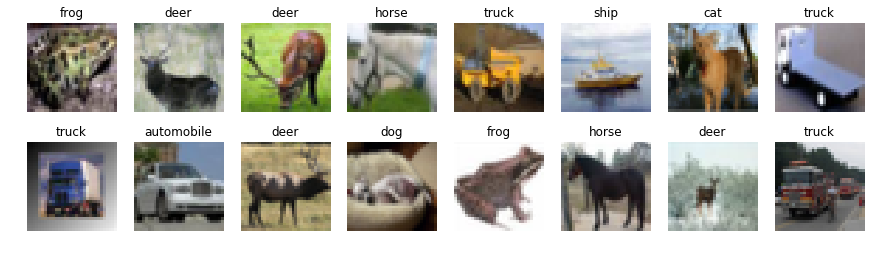

In [24]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Prepare data

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

We need to convert class labels to one-hot encoded vectors. Use __keras.utils.to_categorical__.

In [25]:
# normalize inputs
x_train2 = x_train/255 - 0.5
x_test2 = x_test/255 - 0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train,NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test,NUM_CLASSES)

# Define CNN architecture

In [26]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Convolutional networks are built from several types of layers:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

You need to define a model which takes __(None, 32, 32, 3)__ input and predicts __(None, 10)__ output with probabilities for all classes. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in Keras can be defined in the following way:

```python
model = Sequential()  # start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
model.add(Activation("softmax"))  # output probabilities
```

Stack __4__ convolutional layers with kernel size __(3, 3)__ with growing number of filters __(16, 32, 32, 64)__, use "same" padding.

Add __2x2__ pooling layer after every 2 convolutional layers (conv-conv-pool scheme).

Use __LeakyReLU__ activation with recommended parameter __0.1__ for all layers that need it (after convolutional and dense layers):
```python
model.add(LeakyReLU(0.1))
```

Add a dense layer with __256__ neurons and a second dense layer with __10__ neurons for classes. Remember to use __Flatten__ layer before first dense layer to reshape input volume into a flat vector!

Add __Dropout__ after every pooling layer (__0.25__) and between dense layers (__0.5__).

In [27]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(32,32,3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES))
    model.add(Activation("softmax"))
    
    return model

In [28]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
__________

In [29]:
## GRADED PART, DO NOT CHANGE!
# Number of model parameters
grader.set_answer("7W4tu", grading_utils.model_total_params(model))

In [37]:
# token expires every 30 min
COURSERA_TOKEN = "ZyLApJvflah3pwsX"
COURSERA_EMAIL = "tomar.ankur287@gmail.com"

In [38]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Train model

Training of your model can take approx. 4-8 minutes per epoch.

During training you should observe the decrease in reported loss on training and validation.

If the loss on training is not decreasing with epochs you should revise your model definition and learning rate.

In [39]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

s = reset_tf_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

Training takes approximately **1.5 hours**. You're aiming for ~0.80 validation accuracy.

In [ ]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 7
# model = load_model(model_filename.format(last_finished_epoch))

In [41]:
# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory()],
    validation_data=(x_test2, y_test2),
    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
Learning rate: 0.005


 6464/50000 [==>...........................] - ETA: 12:02 - loss: 2.3080 - acc: 0.06 - ETA: 7:35 - loss: 2.5082 - acc: 0.0312 - ETA: 5:53 - loss: 2.4387 - acc: 0.072 - ETA: 5:04 - loss: 2.4210 - acc: 0.078 - ETA: 4:50 - loss: 2.3811 - acc: 0.112 - ETA: 4:31 - loss: 2.3508 - acc: 0.140 - ETA: 4:16 - loss: 2.3204 - acc: 0.156 - ETA: 4:14 - loss: 2.3170 - acc: 0.160 - ETA: 4:05 - loss: 2.3051 - acc: 0.173 - ETA: 3:59 - loss: 2.2960 - acc: 0.178 - ETA: 3:55 - loss: 2.2954 - acc: 0.181 - ETA: 3:54 - loss: 2.2880 - acc: 0.177 - ETA: 3:49 - loss: 2.2720 - acc: 0.182 - ETA: 3:48 - loss: 2.2644 - acc: 0.187 - ETA: 3:44 - loss: 2.2673 - acc: 0.183 - ETA: 3:41 - loss: 2.2624 - acc: 0.183 - ETA: 3:46 - loss: 2.2501 - acc: 0.193 - ETA: 3:42 - loss: 2.2495 - acc: 0.191 - ETA: 3:42 - loss: 2.2447 - acc: 0.194 - ETA: 3:40 - loss: 2.2452 - acc: 0.193 - ETA: 3:38 - loss: 2.2368 - acc: 0.194 - ETA: 3:37 - loss: 2.2307 - acc: 0.196 - ETA: 3:34 - loss: 2.2265 - acc: 0.194 - ETA: 3:32 - loss: 2.2244 - acc: 

12992/50000 [======>.......................] - ETA: 3:19 - loss: 1.8551 - acc: 0.318 - ETA: 3:18 - loss: 1.8539 - acc: 0.318 - ETA: 3:18 - loss: 1.8528 - acc: 0.318 - ETA: 3:18 - loss: 1.8515 - acc: 0.319 - ETA: 3:18 - loss: 1.8503 - acc: 0.319 - ETA: 3:18 - loss: 1.8488 - acc: 0.319 - ETA: 3:18 - loss: 1.8468 - acc: 0.321 - ETA: 3:17 - loss: 1.8451 - acc: 0.322 - ETA: 3:17 - loss: 1.8439 - acc: 0.322 - ETA: 3:17 - loss: 1.8435 - acc: 0.322 - ETA: 3:17 - loss: 1.8429 - acc: 0.322 - ETA: 3:17 - loss: 1.8404 - acc: 0.323 - ETA: 3:16 - loss: 1.8399 - acc: 0.323 - ETA: 3:16 - loss: 1.8379 - acc: 0.324 - ETA: 3:16 - loss: 1.8359 - acc: 0.325 - ETA: 3:16 - loss: 1.8331 - acc: 0.326 - ETA: 3:16 - loss: 1.8322 - acc: 0.327 - ETA: 3:15 - loss: 1.8315 - acc: 0.327 - ETA: 3:15 - loss: 1.8304 - acc: 0.327 - ETA: 3:15 - loss: 1.8287 - acc: 0.328 - ETA: 3:15 - loss: 1.8269 - acc: 0.328 - ETA: 3:15 - loss: 1.8246 - acc: 0.329 - ETA: 3:15 - loss: 1.8242 - acc: 0.329 - ETA: 3:14 - loss: 1.8221 - acc: 0

19520/50000 [==========>...................] - ETA: 2:47 - loss: 1.6778 - acc: 0.390 - ETA: 2:47 - loss: 1.6764 - acc: 0.390 - ETA: 2:47 - loss: 1.6763 - acc: 0.390 - ETA: 2:46 - loss: 1.6758 - acc: 0.390 - ETA: 2:46 - loss: 1.6744 - acc: 0.391 - ETA: 2:46 - loss: 1.6742 - acc: 0.391 - ETA: 2:46 - loss: 1.6744 - acc: 0.391 - ETA: 2:46 - loss: 1.6741 - acc: 0.391 - ETA: 2:46 - loss: 1.6732 - acc: 0.391 - ETA: 2:46 - loss: 1.6721 - acc: 0.391 - ETA: 2:45 - loss: 1.6719 - acc: 0.391 - ETA: 2:45 - loss: 1.6718 - acc: 0.392 - ETA: 2:45 - loss: 1.6722 - acc: 0.392 - ETA: 2:45 - loss: 1.6712 - acc: 0.392 - ETA: 2:45 - loss: 1.6705 - acc: 0.392 - ETA: 2:45 - loss: 1.6706 - acc: 0.392 - ETA: 2:45 - loss: 1.6693 - acc: 0.393 - ETA: 2:45 - loss: 1.6694 - acc: 0.393 - ETA: 2:44 - loss: 1.6691 - acc: 0.393 - ETA: 2:44 - loss: 1.6690 - acc: 0.394 - ETA: 2:44 - loss: 1.6682 - acc: 0.394 - ETA: 2:44 - loss: 1.6673 - acc: 0.395 - ETA: 2:44 - loss: 1.6671 - acc: 0.394 - ETA: 2:44 - loss: 1.6675 - acc: 0

26048/50000 [==============>...............] - ETA: 2:20 - loss: 1.5802 - acc: 0.429 - ETA: 2:19 - loss: 1.5798 - acc: 0.430 - ETA: 2:19 - loss: 1.5790 - acc: 0.430 - ETA: 2:19 - loss: 1.5786 - acc: 0.430 - ETA: 2:19 - loss: 1.5784 - acc: 0.430 - ETA: 2:19 - loss: 1.5785 - acc: 0.430 - ETA: 2:19 - loss: 1.5780 - acc: 0.430 - ETA: 2:18 - loss: 1.5776 - acc: 0.430 - ETA: 2:18 - loss: 1.5774 - acc: 0.430 - ETA: 2:18 - loss: 1.5770 - acc: 0.430 - ETA: 2:18 - loss: 1.5763 - acc: 0.430 - ETA: 2:18 - loss: 1.5765 - acc: 0.430 - ETA: 2:18 - loss: 1.5758 - acc: 0.430 - ETA: 2:18 - loss: 1.5754 - acc: 0.431 - ETA: 2:18 - loss: 1.5749 - acc: 0.431 - ETA: 2:17 - loss: 1.5744 - acc: 0.431 - ETA: 2:17 - loss: 1.5738 - acc: 0.431 - ETA: 2:17 - loss: 1.5736 - acc: 0.431 - ETA: 2:17 - loss: 1.5732 - acc: 0.431 - ETA: 2:17 - loss: 1.5730 - acc: 0.431 - ETA: 2:17 - loss: 1.5726 - acc: 0.432 - ETA: 2:17 - loss: 1.5721 - acc: 0.432 - ETA: 2:16 - loss: 1.5715 - acc: 0.432 - ETA: 2:16 - loss: 1.5715 - acc: 0

32576/50000 [==================>...........] - ETA: 1:50 - loss: 1.5181 - acc: 0.453 - ETA: 1:50 - loss: 1.5178 - acc: 0.453 - ETA: 1:50 - loss: 1.5174 - acc: 0.453 - ETA: 1:49 - loss: 1.5168 - acc: 0.454 - ETA: 1:49 - loss: 1.5168 - acc: 0.453 - ETA: 1:49 - loss: 1.5167 - acc: 0.453 - ETA: 1:49 - loss: 1.5165 - acc: 0.453 - ETA: 1:49 - loss: 1.5161 - acc: 0.454 - ETA: 1:49 - loss: 1.5159 - acc: 0.454 - ETA: 1:48 - loss: 1.5157 - acc: 0.454 - ETA: 1:48 - loss: 1.5153 - acc: 0.454 - ETA: 1:48 - loss: 1.5154 - acc: 0.454 - ETA: 1:48 - loss: 1.5149 - acc: 0.454 - ETA: 1:48 - loss: 1.5144 - acc: 0.454 - ETA: 1:48 - loss: 1.5142 - acc: 0.455 - ETA: 1:48 - loss: 1.5140 - acc: 0.454 - ETA: 1:47 - loss: 1.5138 - acc: 0.454 - ETA: 1:47 - loss: 1.5132 - acc: 0.455 - ETA: 1:47 - loss: 1.5132 - acc: 0.455 - ETA: 1:47 - loss: 1.5130 - acc: 0.455 - ETA: 1:47 - loss: 1.5126 - acc: 0.455 - ETA: 1:47 - loss: 1.5123 - acc: 0.455 - ETA: 1:46 - loss: 1.5121 - acc: 0.455 - ETA: 1:46 - loss: 1.5120 - acc: 0

39232/50000 [======================>.......] - ETA: 1:19 - loss: 1.4618 - acc: 0.475 - ETA: 1:19 - loss: 1.4618 - acc: 0.475 - ETA: 1:19 - loss: 1.4617 - acc: 0.475 - ETA: 1:19 - loss: 1.4613 - acc: 0.475 - ETA: 1:19 - loss: 1.4612 - acc: 0.475 - ETA: 1:19 - loss: 1.4614 - acc: 0.475 - ETA: 1:18 - loss: 1.4609 - acc: 0.475 - ETA: 1:18 - loss: 1.4608 - acc: 0.475 - ETA: 1:18 - loss: 1.4605 - acc: 0.475 - ETA: 1:18 - loss: 1.4602 - acc: 0.475 - ETA: 1:18 - loss: 1.4599 - acc: 0.475 - ETA: 1:18 - loss: 1.4596 - acc: 0.475 - ETA: 1:18 - loss: 1.4595 - acc: 0.475 - ETA: 1:17 - loss: 1.4592 - acc: 0.475 - ETA: 1:17 - loss: 1.4589 - acc: 0.476 - ETA: 1:17 - loss: 1.4588 - acc: 0.476 - ETA: 1:17 - loss: 1.4588 - acc: 0.476 - ETA: 1:17 - loss: 1.4582 - acc: 0.476 - ETA: 1:17 - loss: 1.4581 - acc: 0.476 - ETA: 1:17 - loss: 1.4578 - acc: 0.476 - ETA: 1:16 - loss: 1.4574 - acc: 0.476 - ETA: 1:16 - loss: 1.4572 - acc: 0.476 - ETA: 1:16 - loss: 1.4568 - acc: 0.476 - ETA: 1:16 - loss: 1.4566 - acc: 0

46112/50000 [==========================>...] - ETA: 49s - loss: 1.4137 - acc: 0.49 - ETA: 49s - loss: 1.4135 - acc: 0.49 - ETA: 49s - loss: 1.4132 - acc: 0.49 - ETA: 48s - loss: 1.4130 - acc: 0.49 - ETA: 48s - loss: 1.4128 - acc: 0.49 - ETA: 48s - loss: 1.4127 - acc: 0.49 - ETA: 48s - loss: 1.4123 - acc: 0.49 - ETA: 48s - loss: 1.4121 - acc: 0.49 - ETA: 48s - loss: 1.4119 - acc: 0.49 - ETA: 47s - loss: 1.4117 - acc: 0.49 - ETA: 47s - loss: 1.4114 - acc: 0.49 - ETA: 47s - loss: 1.4110 - acc: 0.49 - ETA: 47s - loss: 1.4107 - acc: 0.49 - ETA: 47s - loss: 1.4103 - acc: 0.49 - ETA: 47s - loss: 1.4101 - acc: 0.49 - ETA: 47s - loss: 1.4098 - acc: 0.49 - ETA: 46s - loss: 1.4093 - acc: 0.49 - ETA: 46s - loss: 1.4090 - acc: 0.49 - ETA: 46s - loss: 1.4087 - acc: 0.49 - ETA: 46s - loss: 1.4082 - acc: 0.49 - ETA: 46s - loss: 1.4077 - acc: 0.49 - ETA: 46s - loss: 1.4075 - acc: 0.49 - ETA: 45s - loss: 1.4073 - acc: 0.49 - ETA: 45s - loss: 1.4072 - acc: 0.49 - ETA: 45s - loss: 1.4069 - acc: 0.49 - ETA

50000/50000 [==============================] - ETA: 17s - loss: 1.3726 - acc: 0.50 - ETA: 17s - loss: 1.3725 - acc: 0.50 - ETA: 17s - loss: 1.3724 - acc: 0.50 - ETA: 17s - loss: 1.3723 - acc: 0.50 - ETA: 17s - loss: 1.3723 - acc: 0.50 - ETA: 17s - loss: 1.3722 - acc: 0.50 - ETA: 16s - loss: 1.3719 - acc: 0.50 - ETA: 16s - loss: 1.3716 - acc: 0.50 - ETA: 16s - loss: 1.3715 - acc: 0.50 - ETA: 16s - loss: 1.3713 - acc: 0.50 - ETA: 16s - loss: 1.3710 - acc: 0.50 - ETA: 16s - loss: 1.3708 - acc: 0.50 - ETA: 15s - loss: 1.3706 - acc: 0.50 - ETA: 15s - loss: 1.3707 - acc: 0.50 - ETA: 15s - loss: 1.3705 - acc: 0.50 - ETA: 15s - loss: 1.3704 - acc: 0.50 - ETA: 15s - loss: 1.3702 - acc: 0.50 - ETA: 15s - loss: 1.3699 - acc: 0.50 - ETA: 15s - loss: 1.3695 - acc: 0.50 - ETA: 14s - loss: 1.3695 - acc: 0.50 - ETA: 14s - loss: 1.3695 - acc: 0.50 - ETA: 14s - loss: 1.3693 - acc: 0.50 - ETA: 14s - loss: 1.3691 - acc: 0.50 - ETA: 14s - loss: 1.3686 - acc: 0.50 - ETA: 14s - loss: 1.3684 - acc: 0.50 - ETA

 6528/50000 [==>...........................] - ETA: 3:52 - loss: 1.0628 - acc: 0.593 - ETA: 3:34 - loss: 1.1311 - acc: 0.593 - ETA: 3:38 - loss: 1.1774 - acc: 0.583 - ETA: 3:35 - loss: 1.1859 - acc: 0.570 - ETA: 3:32 - loss: 1.1044 - acc: 0.606 - ETA: 3:37 - loss: 1.0779 - acc: 0.625 - ETA: 3:35 - loss: 1.0845 - acc: 0.620 - ETA: 3:44 - loss: 1.0685 - acc: 0.628 - ETA: 3:46 - loss: 1.0719 - acc: 0.621 - ETA: 3:45 - loss: 1.0746 - acc: 0.615 - ETA: 3:42 - loss: 1.0806 - acc: 0.605 - ETA: 3:51 - loss: 1.0607 - acc: 0.617 - ETA: 3:57 - loss: 1.0648 - acc: 0.620 - ETA: 4:08 - loss: 1.0411 - acc: 0.629 - ETA: 4:08 - loss: 1.0433 - acc: 0.625 - ETA: 4:08 - loss: 1.0338 - acc: 0.621 - ETA: 4:08 - loss: 1.0288 - acc: 0.617 - ETA: 4:07 - loss: 1.0199 - acc: 0.623 - ETA: 4:06 - loss: 1.0206 - acc: 0.625 - ETA: 4:07 - loss: 1.0182 - acc: 0.621 - ETA: 4:08 - loss: 1.0083 - acc: 0.626 - ETA: 4:09 - loss: 1.0010 - acc: 0.633 - ETA: 4:10 - loss: 1.0052 - acc: 0.631 - ETA: 4:07 - loss: 1.0316 - acc: 0

13056/50000 [======>.......................] - ETA: 3:13 - loss: 1.0238 - acc: 0.636 - ETA: 3:13 - loss: 1.0232 - acc: 0.636 - ETA: 3:13 - loss: 1.0243 - acc: 0.636 - ETA: 3:13 - loss: 1.0231 - acc: 0.636 - ETA: 3:13 - loss: 1.0234 - acc: 0.636 - ETA: 3:12 - loss: 1.0220 - acc: 0.637 - ETA: 3:12 - loss: 1.0229 - acc: 0.636 - ETA: 3:12 - loss: 1.0219 - acc: 0.636 - ETA: 3:12 - loss: 1.0211 - acc: 0.636 - ETA: 3:12 - loss: 1.0208 - acc: 0.636 - ETA: 3:11 - loss: 1.0218 - acc: 0.636 - ETA: 3:11 - loss: 1.0212 - acc: 0.636 - ETA: 3:11 - loss: 1.0217 - acc: 0.637 - ETA: 3:11 - loss: 1.0225 - acc: 0.636 - ETA: 3:11 - loss: 1.0222 - acc: 0.636 - ETA: 3:11 - loss: 1.0221 - acc: 0.636 - ETA: 3:11 - loss: 1.0220 - acc: 0.636 - ETA: 3:10 - loss: 1.0210 - acc: 0.637 - ETA: 3:10 - loss: 1.0228 - acc: 0.636 - ETA: 3:10 - loss: 1.0227 - acc: 0.636 - ETA: 3:10 - loss: 1.0237 - acc: 0.636 - ETA: 3:10 - loss: 1.0238 - acc: 0.636 - ETA: 3:09 - loss: 1.0241 - acc: 0.636 - ETA: 3:09 - loss: 1.0255 - acc: 0

19584/50000 [==========>...................] - ETA: 2:47 - loss: 1.0149 - acc: 0.641 - ETA: 2:46 - loss: 1.0152 - acc: 0.641 - ETA: 2:46 - loss: 1.0145 - acc: 0.641 - ETA: 2:46 - loss: 1.0152 - acc: 0.641 - ETA: 2:46 - loss: 1.0150 - acc: 0.641 - ETA: 2:46 - loss: 1.0153 - acc: 0.641 - ETA: 2:46 - loss: 1.0158 - acc: 0.640 - ETA: 2:46 - loss: 1.0156 - acc: 0.640 - ETA: 2:46 - loss: 1.0152 - acc: 0.641 - ETA: 2:46 - loss: 1.0149 - acc: 0.641 - ETA: 2:46 - loss: 1.0143 - acc: 0.641 - ETA: 2:45 - loss: 1.0137 - acc: 0.641 - ETA: 2:45 - loss: 1.0131 - acc: 0.642 - ETA: 2:45 - loss: 1.0126 - acc: 0.642 - ETA: 2:45 - loss: 1.0121 - acc: 0.642 - ETA: 2:45 - loss: 1.0125 - acc: 0.642 - ETA: 2:45 - loss: 1.0124 - acc: 0.642 - ETA: 2:44 - loss: 1.0126 - acc: 0.641 - ETA: 2:44 - loss: 1.0133 - acc: 0.641 - ETA: 2:44 - loss: 1.0133 - acc: 0.641 - ETA: 2:44 - loss: 1.0128 - acc: 0.641 - ETA: 2:44 - loss: 1.0131 - acc: 0.641 - ETA: 2:44 - loss: 1.0130 - acc: 0.641 - ETA: 2:44 - loss: 1.0129 - acc: 0

26112/50000 [==============>...............] - ETA: 2:18 - loss: 1.0068 - acc: 0.644 - ETA: 2:18 - loss: 1.0064 - acc: 0.644 - ETA: 2:18 - loss: 1.0064 - acc: 0.644 - ETA: 2:18 - loss: 1.0065 - acc: 0.644 - ETA: 2:18 - loss: 1.0064 - acc: 0.644 - ETA: 2:18 - loss: 1.0067 - acc: 0.644 - ETA: 2:18 - loss: 1.0071 - acc: 0.644 - ETA: 2:17 - loss: 1.0074 - acc: 0.644 - ETA: 2:17 - loss: 1.0072 - acc: 0.644 - ETA: 2:17 - loss: 1.0074 - acc: 0.644 - ETA: 2:17 - loss: 1.0077 - acc: 0.643 - ETA: 2:17 - loss: 1.0076 - acc: 0.643 - ETA: 2:17 - loss: 1.0078 - acc: 0.643 - ETA: 2:17 - loss: 1.0076 - acc: 0.643 - ETA: 2:17 - loss: 1.0074 - acc: 0.644 - ETA: 2:17 - loss: 1.0072 - acc: 0.644 - ETA: 2:17 - loss: 1.0068 - acc: 0.644 - ETA: 2:17 - loss: 1.0072 - acc: 0.644 - ETA: 2:16 - loss: 1.0071 - acc: 0.644 - ETA: 2:16 - loss: 1.0070 - acc: 0.644 - ETA: 2:16 - loss: 1.0065 - acc: 0.644 - ETA: 2:16 - loss: 1.0063 - acc: 0.644 - ETA: 2:16 - loss: 1.0062 - acc: 0.644 - ETA: 2:16 - loss: 1.0061 - acc: 0

32640/50000 [==================>...........] - ETA: 1:52 - loss: 0.9963 - acc: 0.647 - ETA: 1:51 - loss: 0.9962 - acc: 0.647 - ETA: 1:51 - loss: 0.9963 - acc: 0.647 - ETA: 1:51 - loss: 0.9961 - acc: 0.647 - ETA: 1:51 - loss: 0.9962 - acc: 0.647 - ETA: 1:51 - loss: 0.9964 - acc: 0.647 - ETA: 1:51 - loss: 0.9960 - acc: 0.647 - ETA: 1:51 - loss: 0.9957 - acc: 0.647 - ETA: 1:51 - loss: 0.9957 - acc: 0.647 - ETA: 1:50 - loss: 0.9960 - acc: 0.647 - ETA: 1:50 - loss: 0.9956 - acc: 0.647 - ETA: 1:50 - loss: 0.9959 - acc: 0.647 - ETA: 1:50 - loss: 0.9956 - acc: 0.647 - ETA: 1:50 - loss: 0.9955 - acc: 0.647 - ETA: 1:50 - loss: 0.9954 - acc: 0.647 - ETA: 1:50 - loss: 0.9954 - acc: 0.647 - ETA: 1:50 - loss: 0.9954 - acc: 0.647 - ETA: 1:49 - loss: 0.9952 - acc: 0.648 - ETA: 1:49 - loss: 0.9950 - acc: 0.647 - ETA: 1:49 - loss: 0.9952 - acc: 0.647 - ETA: 1:49 - loss: 0.9961 - acc: 0.647 - ETA: 1:49 - loss: 0.9963 - acc: 0.647 - ETA: 1:49 - loss: 0.9968 - acc: 0.647 - ETA: 1:49 - loss: 0.9967 - acc: 0

39264/50000 [======================>.......] - ETA: 1:21 - loss: 0.9929 - acc: 0.648 - ETA: 1:21 - loss: 0.9928 - acc: 0.648 - ETA: 1:21 - loss: 0.9926 - acc: 0.648 - ETA: 1:20 - loss: 0.9925 - acc: 0.648 - ETA: 1:20 - loss: 0.9922 - acc: 0.648 - ETA: 1:20 - loss: 0.9926 - acc: 0.648 - ETA: 1:20 - loss: 0.9924 - acc: 0.648 - ETA: 1:20 - loss: 0.9923 - acc: 0.648 - ETA: 1:20 - loss: 0.9921 - acc: 0.649 - ETA: 1:20 - loss: 0.9919 - acc: 0.649 - ETA: 1:19 - loss: 0.9915 - acc: 0.649 - ETA: 1:19 - loss: 0.9917 - acc: 0.649 - ETA: 1:19 - loss: 0.9917 - acc: 0.649 - ETA: 1:19 - loss: 0.9916 - acc: 0.649 - ETA: 1:19 - loss: 0.9919 - acc: 0.649 - ETA: 1:19 - loss: 0.9918 - acc: 0.649 - ETA: 1:18 - loss: 0.9916 - acc: 0.649 - ETA: 1:18 - loss: 0.9914 - acc: 0.649 - ETA: 1:18 - loss: 0.9911 - acc: 0.649 - ETA: 1:18 - loss: 0.9913 - acc: 0.649 - ETA: 1:18 - loss: 0.9914 - acc: 0.649 - ETA: 1:18 - loss: 0.9912 - acc: 0.649 - ETA: 1:17 - loss: 0.9911 - acc: 0.649 - ETA: 1:17 - loss: 0.9910 - acc: 0

46144/50000 [==========================>...] - ETA: 50s - loss: 0.9890 - acc: 0.64 - ETA: 50s - loss: 0.9888 - acc: 0.64 - ETA: 50s - loss: 0.9891 - acc: 0.64 - ETA: 50s - loss: 0.9890 - acc: 0.64 - ETA: 50s - loss: 0.9888 - acc: 0.64 - ETA: 49s - loss: 0.9883 - acc: 0.64 - ETA: 49s - loss: 0.9882 - acc: 0.64 - ETA: 49s - loss: 0.9882 - acc: 0.64 - ETA: 49s - loss: 0.9879 - acc: 0.64 - ETA: 49s - loss: 0.9877 - acc: 0.64 - ETA: 49s - loss: 0.9879 - acc: 0.64 - ETA: 49s - loss: 0.9879 - acc: 0.64 - ETA: 48s - loss: 0.9878 - acc: 0.64 - ETA: 48s - loss: 0.9878 - acc: 0.64 - ETA: 48s - loss: 0.9880 - acc: 0.64 - ETA: 48s - loss: 0.9876 - acc: 0.64 - ETA: 48s - loss: 0.9879 - acc: 0.64 - ETA: 48s - loss: 0.9879 - acc: 0.64 - ETA: 47s - loss: 0.9879 - acc: 0.64 - ETA: 47s - loss: 0.9878 - acc: 0.64 - ETA: 47s - loss: 0.9879 - acc: 0.64 - ETA: 47s - loss: 0.9878 - acc: 0.64 - ETA: 47s - loss: 0.9878 - acc: 0.64 - ETA: 47s - loss: 0.9879 - acc: 0.64 - ETA: 47s - loss: 0.9877 - acc: 0.64 - ETA

50000/50000 [==============================] - ETA: 18s - loss: 0.9790 - acc: 0.65 - ETA: 18s - loss: 0.9789 - acc: 0.65 - ETA: 18s - loss: 0.9788 - acc: 0.65 - ETA: 17s - loss: 0.9790 - acc: 0.65 - ETA: 17s - loss: 0.9788 - acc: 0.65 - ETA: 17s - loss: 0.9786 - acc: 0.65 - ETA: 17s - loss: 0.9785 - acc: 0.65 - ETA: 17s - loss: 0.9783 - acc: 0.65 - ETA: 17s - loss: 0.9781 - acc: 0.65 - ETA: 17s - loss: 0.9779 - acc: 0.65 - ETA: 16s - loss: 0.9779 - acc: 0.65 - ETA: 16s - loss: 0.9779 - acc: 0.65 - ETA: 16s - loss: 0.9780 - acc: 0.65 - ETA: 16s - loss: 0.9779 - acc: 0.65 - ETA: 16s - loss: 0.9781 - acc: 0.65 - ETA: 16s - loss: 0.9782 - acc: 0.65 - ETA: 15s - loss: 0.9782 - acc: 0.65 - ETA: 15s - loss: 0.9781 - acc: 0.65 - ETA: 15s - loss: 0.9781 - acc: 0.65 - ETA: 15s - loss: 0.9783 - acc: 0.65 - ETA: 15s - loss: 0.9785 - acc: 0.65 - ETA: 15s - loss: 0.9785 - acc: 0.65 - ETA: 15s - loss: 0.9786 - acc: 0.65 - ETA: 14s - loss: 0.9786 - acc: 0.65 - ETA: 14s - loss: 0.9786 - acc: 0.65 - ETA

 6528/50000 [==>...........................] - ETA: 4:04 - loss: 0.6310 - acc: 0.750 - ETA: 3:40 - loss: 0.7600 - acc: 0.718 - ETA: 3:31 - loss: 0.8558 - acc: 0.729 - ETA: 3:33 - loss: 0.9048 - acc: 0.703 - ETA: 3:34 - loss: 0.9204 - acc: 0.693 - ETA: 3:35 - loss: 0.8955 - acc: 0.703 - ETA: 3:35 - loss: 0.8746 - acc: 0.687 - ETA: 3:33 - loss: 0.8385 - acc: 0.699 - ETA: 3:34 - loss: 0.8086 - acc: 0.715 - ETA: 3:32 - loss: 0.7970 - acc: 0.721 - ETA: 3:31 - loss: 0.7982 - acc: 0.718 - ETA: 3:29 - loss: 0.7909 - acc: 0.726 - ETA: 3:28 - loss: 0.8063 - acc: 0.721 - ETA: 3:29 - loss: 0.8009 - acc: 0.721 - ETA: 3:28 - loss: 0.7895 - acc: 0.722 - ETA: 3:27 - loss: 0.7869 - acc: 0.720 - ETA: 3:28 - loss: 0.7951 - acc: 0.711 - ETA: 3:27 - loss: 0.7894 - acc: 0.715 - ETA: 3:28 - loss: 0.7919 - acc: 0.713 - ETA: 3:27 - loss: 0.7924 - acc: 0.717 - ETA: 3:26 - loss: 0.8113 - acc: 0.715 - ETA: 3:27 - loss: 0.8087 - acc: 0.715 - ETA: 3:27 - loss: 0.8068 - acc: 0.713 - ETA: 3:27 - loss: 0.8186 - acc: 0

13056/50000 [======>.......................] - ETA: 3:03 - loss: 0.8346 - acc: 0.710 - ETA: 3:02 - loss: 0.8336 - acc: 0.711 - ETA: 3:02 - loss: 0.8326 - acc: 0.711 - ETA: 3:02 - loss: 0.8336 - acc: 0.711 - ETA: 3:02 - loss: 0.8342 - acc: 0.710 - ETA: 3:02 - loss: 0.8344 - acc: 0.710 - ETA: 3:02 - loss: 0.8332 - acc: 0.710 - ETA: 3:02 - loss: 0.8310 - acc: 0.711 - ETA: 3:02 - loss: 0.8326 - acc: 0.710 - ETA: 3:01 - loss: 0.8341 - acc: 0.710 - ETA: 3:01 - loss: 0.8357 - acc: 0.709 - ETA: 3:01 - loss: 0.8355 - acc: 0.709 - ETA: 3:01 - loss: 0.8350 - acc: 0.710 - ETA: 3:01 - loss: 0.8349 - acc: 0.710 - ETA: 3:01 - loss: 0.8354 - acc: 0.710 - ETA: 3:01 - loss: 0.8347 - acc: 0.709 - ETA: 3:00 - loss: 0.8350 - acc: 0.710 - ETA: 3:00 - loss: 0.8342 - acc: 0.710 - ETA: 3:00 - loss: 0.8354 - acc: 0.709 - ETA: 3:00 - loss: 0.8368 - acc: 0.709 - ETA: 3:00 - loss: 0.8368 - acc: 0.709 - ETA: 3:00 - loss: 0.8356 - acc: 0.709 - ETA: 3:00 - loss: 0.8354 - acc: 0.709 - ETA: 2:59 - loss: 0.8349 - acc: 0

19584/50000 [==========>...................] - ETA: 2:46 - loss: 0.8404 - acc: 0.705 - ETA: 2:46 - loss: 0.8405 - acc: 0.705 - ETA: 2:46 - loss: 0.8402 - acc: 0.705 - ETA: 2:47 - loss: 0.8390 - acc: 0.705 - ETA: 2:47 - loss: 0.8389 - acc: 0.705 - ETA: 2:47 - loss: 0.8384 - acc: 0.706 - ETA: 2:47 - loss: 0.8383 - acc: 0.706 - ETA: 2:47 - loss: 0.8390 - acc: 0.706 - ETA: 2:47 - loss: 0.8382 - acc: 0.706 - ETA: 2:47 - loss: 0.8381 - acc: 0.706 - ETA: 2:46 - loss: 0.8384 - acc: 0.706 - ETA: 2:46 - loss: 0.8384 - acc: 0.705 - ETA: 2:46 - loss: 0.8383 - acc: 0.705 - ETA: 2:46 - loss: 0.8375 - acc: 0.705 - ETA: 2:46 - loss: 0.8385 - acc: 0.705 - ETA: 2:46 - loss: 0.8380 - acc: 0.705 - ETA: 2:45 - loss: 0.8382 - acc: 0.705 - ETA: 2:45 - loss: 0.8381 - acc: 0.705 - ETA: 2:45 - loss: 0.8379 - acc: 0.705 - ETA: 2:45 - loss: 0.8375 - acc: 0.705 - ETA: 2:45 - loss: 0.8373 - acc: 0.706 - ETA: 2:45 - loss: 0.8371 - acc: 0.706 - ETA: 2:45 - loss: 0.8368 - acc: 0.706 - ETA: 2:45 - loss: 0.8374 - acc: 0

26112/50000 [==============>...............] - ETA: 2:19 - loss: 0.8366 - acc: 0.707 - ETA: 2:19 - loss: 0.8365 - acc: 0.706 - ETA: 2:19 - loss: 0.8361 - acc: 0.707 - ETA: 2:19 - loss: 0.8364 - acc: 0.706 - ETA: 2:19 - loss: 0.8362 - acc: 0.706 - ETA: 2:19 - loss: 0.8368 - acc: 0.706 - ETA: 2:18 - loss: 0.8370 - acc: 0.706 - ETA: 2:18 - loss: 0.8369 - acc: 0.706 - ETA: 2:18 - loss: 0.8372 - acc: 0.706 - ETA: 2:18 - loss: 0.8370 - acc: 0.706 - ETA: 2:18 - loss: 0.8370 - acc: 0.706 - ETA: 2:18 - loss: 0.8375 - acc: 0.706 - ETA: 2:18 - loss: 0.8377 - acc: 0.705 - ETA: 2:17 - loss: 0.8375 - acc: 0.705 - ETA: 2:17 - loss: 0.8376 - acc: 0.705 - ETA: 2:17 - loss: 0.8374 - acc: 0.705 - ETA: 2:17 - loss: 0.8378 - acc: 0.705 - ETA: 2:17 - loss: 0.8376 - acc: 0.705 - ETA: 2:17 - loss: 0.8380 - acc: 0.705 - ETA: 2:16 - loss: 0.8381 - acc: 0.705 - ETA: 2:16 - loss: 0.8380 - acc: 0.705 - ETA: 2:16 - loss: 0.8377 - acc: 0.705 - ETA: 2:16 - loss: 0.8377 - acc: 0.706 - ETA: 2:16 - loss: 0.8371 - acc: 0

32640/50000 [==================>...........] - ETA: 1:50 - loss: 0.8446 - acc: 0.703 - ETA: 1:50 - loss: 0.8452 - acc: 0.703 - ETA: 1:49 - loss: 0.8451 - acc: 0.703 - ETA: 1:49 - loss: 0.8450 - acc: 0.703 - ETA: 1:49 - loss: 0.8449 - acc: 0.703 - ETA: 1:49 - loss: 0.8447 - acc: 0.703 - ETA: 1:49 - loss: 0.8446 - acc: 0.703 - ETA: 1:49 - loss: 0.8446 - acc: 0.703 - ETA: 1:48 - loss: 0.8449 - acc: 0.703 - ETA: 1:48 - loss: 0.8446 - acc: 0.703 - ETA: 1:48 - loss: 0.8449 - acc: 0.703 - ETA: 1:48 - loss: 0.8448 - acc: 0.703 - ETA: 1:48 - loss: 0.8451 - acc: 0.703 - ETA: 1:48 - loss: 0.8455 - acc: 0.703 - ETA: 1:48 - loss: 0.8455 - acc: 0.703 - ETA: 1:48 - loss: 0.8456 - acc: 0.703 - ETA: 1:47 - loss: 0.8454 - acc: 0.703 - ETA: 1:47 - loss: 0.8452 - acc: 0.703 - ETA: 1:47 - loss: 0.8454 - acc: 0.703 - ETA: 1:47 - loss: 0.8450 - acc: 0.703 - ETA: 1:47 - loss: 0.8452 - acc: 0.703 - ETA: 1:47 - loss: 0.8451 - acc: 0.703 - ETA: 1:47 - loss: 0.8449 - acc: 0.703 - ETA: 1:47 - loss: 0.8449 - acc: 0

39232/50000 [======================>.......] - ETA: 1:26 - loss: 0.8430 - acc: 0.704 - ETA: 1:26 - loss: 0.8430 - acc: 0.704 - ETA: 1:25 - loss: 0.8430 - acc: 0.704 - ETA: 1:25 - loss: 0.8428 - acc: 0.704 - ETA: 1:25 - loss: 0.8427 - acc: 0.704 - ETA: 1:25 - loss: 0.8427 - acc: 0.704 - ETA: 1:25 - loss: 0.8426 - acc: 0.704 - ETA: 1:25 - loss: 0.8423 - acc: 0.705 - ETA: 1:25 - loss: 0.8425 - acc: 0.705 - ETA: 1:24 - loss: 0.8425 - acc: 0.705 - ETA: 1:24 - loss: 0.8423 - acc: 0.705 - ETA: 1:24 - loss: 0.8419 - acc: 0.705 - ETA: 1:24 - loss: 0.8417 - acc: 0.705 - ETA: 1:24 - loss: 0.8415 - acc: 0.705 - ETA: 1:24 - loss: 0.8417 - acc: 0.705 - ETA: 1:24 - loss: 0.8415 - acc: 0.705 - ETA: 1:24 - loss: 0.8415 - acc: 0.705 - ETA: 1:23 - loss: 0.8414 - acc: 0.705 - ETA: 1:23 - loss: 0.8414 - acc: 0.705 - ETA: 1:23 - loss: 0.8412 - acc: 0.705 - ETA: 1:23 - loss: 0.8411 - acc: 0.705 - ETA: 1:23 - loss: 0.8413 - acc: 0.705 - ETA: 1:23 - loss: 0.8413 - acc: 0.705 - ETA: 1:23 - loss: 0.8413 - acc: 0

46112/50000 [==========================>...] - ETA: 54s - loss: 0.8391 - acc: 0.70 - ETA: 54s - loss: 0.8390 - acc: 0.70 - ETA: 54s - loss: 0.8391 - acc: 0.70 - ETA: 54s - loss: 0.8392 - acc: 0.70 - ETA: 54s - loss: 0.8390 - acc: 0.70 - ETA: 53s - loss: 0.8390 - acc: 0.70 - ETA: 53s - loss: 0.8389 - acc: 0.70 - ETA: 53s - loss: 0.8389 - acc: 0.70 - ETA: 53s - loss: 0.8389 - acc: 0.70 - ETA: 53s - loss: 0.8388 - acc: 0.70 - ETA: 53s - loss: 0.8389 - acc: 0.70 - ETA: 52s - loss: 0.8387 - acc: 0.70 - ETA: 52s - loss: 0.8389 - acc: 0.70 - ETA: 52s - loss: 0.8387 - acc: 0.70 - ETA: 52s - loss: 0.8386 - acc: 0.70 - ETA: 52s - loss: 0.8385 - acc: 0.70 - ETA: 52s - loss: 0.8383 - acc: 0.70 - ETA: 51s - loss: 0.8382 - acc: 0.70 - ETA: 51s - loss: 0.8382 - acc: 0.70 - ETA: 51s - loss: 0.8381 - acc: 0.70 - ETA: 51s - loss: 0.8382 - acc: 0.70 - ETA: 51s - loss: 0.8380 - acc: 0.70 - ETA: 51s - loss: 0.8380 - acc: 0.70 - ETA: 51s - loss: 0.8380 - acc: 0.70 - ETA: 50s - loss: 0.8380 - acc: 0.70 - ETA

50000/50000 [==============================] - ETA: 20s - loss: 0.8352 - acc: 0.70 - ETA: 19s - loss: 0.8351 - acc: 0.70 - ETA: 19s - loss: 0.8350 - acc: 0.70 - ETA: 19s - loss: 0.8347 - acc: 0.70 - ETA: 19s - loss: 0.8346 - acc: 0.70 - ETA: 19s - loss: 0.8345 - acc: 0.70 - ETA: 19s - loss: 0.8342 - acc: 0.70 - ETA: 18s - loss: 0.8342 - acc: 0.70 - ETA: 18s - loss: 0.8342 - acc: 0.70 - ETA: 18s - loss: 0.8342 - acc: 0.70 - ETA: 18s - loss: 0.8343 - acc: 0.70 - ETA: 18s - loss: 0.8342 - acc: 0.70 - ETA: 18s - loss: 0.8342 - acc: 0.70 - ETA: 17s - loss: 0.8339 - acc: 0.70 - ETA: 17s - loss: 0.8338 - acc: 0.70 - ETA: 17s - loss: 0.8335 - acc: 0.70 - ETA: 17s - loss: 0.8333 - acc: 0.70 - ETA: 17s - loss: 0.8334 - acc: 0.70 - ETA: 17s - loss: 0.8339 - acc: 0.70 - ETA: 16s - loss: 0.8340 - acc: 0.70 - ETA: 16s - loss: 0.8338 - acc: 0.70 - ETA: 16s - loss: 0.8342 - acc: 0.70 - ETA: 16s - loss: 0.8341 - acc: 0.70 - ETA: 16s - loss: 0.8341 - acc: 0.70 - ETA: 16s - loss: 0.8340 - acc: 0.70 - ETA

 6528/50000 [==>...........................] - ETA: 4:37 - loss: 0.9041 - acc: 0.718 - ETA: 4:22 - loss: 0.8165 - acc: 0.687 - ETA: 4:26 - loss: 0.7184 - acc: 0.729 - ETA: 4:32 - loss: 0.8411 - acc: 0.679 - ETA: 4:34 - loss: 0.7788 - acc: 0.706 - ETA: 4:34 - loss: 0.7585 - acc: 0.729 - ETA: 4:34 - loss: 0.7528 - acc: 0.727 - ETA: 4:37 - loss: 0.7434 - acc: 0.730 - ETA: 4:35 - loss: 0.7186 - acc: 0.736 - ETA: 4:35 - loss: 0.7427 - acc: 0.734 - ETA: 4:34 - loss: 0.7712 - acc: 0.727 - ETA: 4:34 - loss: 0.7705 - acc: 0.729 - ETA: 4:35 - loss: 0.7763 - acc: 0.726 - ETA: 4:36 - loss: 0.7910 - acc: 0.718 - ETA: 4:36 - loss: 0.7863 - acc: 0.718 - ETA: 4:35 - loss: 0.7976 - acc: 0.716 - ETA: 4:36 - loss: 0.8085 - acc: 0.713 - ETA: 4:36 - loss: 0.8052 - acc: 0.715 - ETA: 4:36 - loss: 0.7962 - acc: 0.718 - ETA: 4:36 - loss: 0.8112 - acc: 0.710 - ETA: 4:36 - loss: 0.8145 - acc: 0.711 - ETA: 4:36 - loss: 0.8115 - acc: 0.711 - ETA: 4:35 - loss: 0.8068 - acc: 0.713 - ETA: 4:34 - loss: 0.8058 - acc: 0

13056/50000 [======>.......................] - ETA: 4:04 - loss: 0.7486 - acc: 0.736 - ETA: 4:03 - loss: 0.7488 - acc: 0.735 - ETA: 4:03 - loss: 0.7497 - acc: 0.734 - ETA: 4:03 - loss: 0.7492 - acc: 0.735 - ETA: 4:03 - loss: 0.7481 - acc: 0.735 - ETA: 4:03 - loss: 0.7475 - acc: 0.735 - ETA: 4:02 - loss: 0.7477 - acc: 0.735 - ETA: 4:02 - loss: 0.7477 - acc: 0.736 - ETA: 4:02 - loss: 0.7466 - acc: 0.736 - ETA: 4:02 - loss: 0.7459 - acc: 0.736 - ETA: 4:02 - loss: 0.7453 - acc: 0.736 - ETA: 4:01 - loss: 0.7451 - acc: 0.736 - ETA: 4:01 - loss: 0.7457 - acc: 0.737 - ETA: 4:01 - loss: 0.7444 - acc: 0.737 - ETA: 4:01 - loss: 0.7440 - acc: 0.737 - ETA: 4:01 - loss: 0.7441 - acc: 0.737 - ETA: 4:01 - loss: 0.7439 - acc: 0.737 - ETA: 4:00 - loss: 0.7435 - acc: 0.737 - ETA: 4:00 - loss: 0.7436 - acc: 0.737 - ETA: 4:00 - loss: 0.7452 - acc: 0.736 - ETA: 4:00 - loss: 0.7453 - acc: 0.736 - ETA: 4:00 - loss: 0.7453 - acc: 0.736 - ETA: 3:59 - loss: 0.7457 - acc: 0.736 - ETA: 3:59 - loss: 0.7452 - acc: 0

19584/50000 [==========>...................] - ETA: 3:24 - loss: 0.7403 - acc: 0.736 - ETA: 3:24 - loss: 0.7403 - acc: 0.736 - ETA: 3:23 - loss: 0.7400 - acc: 0.736 - ETA: 3:23 - loss: 0.7394 - acc: 0.736 - ETA: 3:23 - loss: 0.7390 - acc: 0.736 - ETA: 3:23 - loss: 0.7382 - acc: 0.736 - ETA: 3:23 - loss: 0.7384 - acc: 0.736 - ETA: 3:23 - loss: 0.7384 - acc: 0.736 - ETA: 3:23 - loss: 0.7383 - acc: 0.736 - ETA: 3:22 - loss: 0.7390 - acc: 0.736 - ETA: 3:22 - loss: 0.7396 - acc: 0.735 - ETA: 3:22 - loss: 0.7397 - acc: 0.735 - ETA: 3:22 - loss: 0.7395 - acc: 0.736 - ETA: 3:22 - loss: 0.7404 - acc: 0.735 - ETA: 3:22 - loss: 0.7400 - acc: 0.736 - ETA: 3:22 - loss: 0.7401 - acc: 0.736 - ETA: 3:22 - loss: 0.7401 - acc: 0.736 - ETA: 3:21 - loss: 0.7399 - acc: 0.736 - ETA: 3:21 - loss: 0.7395 - acc: 0.736 - ETA: 3:21 - loss: 0.7398 - acc: 0.736 - ETA: 3:21 - loss: 0.7396 - acc: 0.736 - ETA: 3:21 - loss: 0.7396 - acc: 0.736 - ETA: 3:21 - loss: 0.7394 - acc: 0.736 - ETA: 3:20 - loss: 0.7399 - acc: 0

26112/50000 [==============>...............] - ETA: 2:50 - loss: 0.7447 - acc: 0.737 - ETA: 2:50 - loss: 0.7444 - acc: 0.737 - ETA: 2:50 - loss: 0.7445 - acc: 0.737 - ETA: 2:50 - loss: 0.7444 - acc: 0.737 - ETA: 2:50 - loss: 0.7446 - acc: 0.737 - ETA: 2:49 - loss: 0.7441 - acc: 0.737 - ETA: 2:49 - loss: 0.7442 - acc: 0.737 - ETA: 2:49 - loss: 0.7441 - acc: 0.737 - ETA: 2:49 - loss: 0.7440 - acc: 0.737 - ETA: 2:49 - loss: 0.7446 - acc: 0.737 - ETA: 2:48 - loss: 0.7443 - acc: 0.737 - ETA: 2:48 - loss: 0.7450 - acc: 0.737 - ETA: 2:48 - loss: 0.7451 - acc: 0.737 - ETA: 2:48 - loss: 0.7445 - acc: 0.737 - ETA: 2:48 - loss: 0.7446 - acc: 0.737 - ETA: 2:48 - loss: 0.7444 - acc: 0.737 - ETA: 2:47 - loss: 0.7442 - acc: 0.737 - ETA: 2:47 - loss: 0.7435 - acc: 0.737 - ETA: 2:47 - loss: 0.7431 - acc: 0.737 - ETA: 2:47 - loss: 0.7431 - acc: 0.737 - ETA: 2:47 - loss: 0.7433 - acc: 0.737 - ETA: 2:47 - loss: 0.7434 - acc: 0.737 - ETA: 2:46 - loss: 0.7437 - acc: 0.737 - ETA: 2:46 - loss: 0.7436 - acc: 0

32640/50000 [==================>...........] - ETA: 2:14 - loss: 0.7414 - acc: 0.738 - ETA: 2:13 - loss: 0.7417 - acc: 0.738 - ETA: 2:13 - loss: 0.7416 - acc: 0.738 - ETA: 2:13 - loss: 0.7414 - acc: 0.738 - ETA: 2:13 - loss: 0.7415 - acc: 0.737 - ETA: 2:13 - loss: 0.7417 - acc: 0.737 - ETA: 2:12 - loss: 0.7415 - acc: 0.737 - ETA: 2:12 - loss: 0.7416 - acc: 0.737 - ETA: 2:12 - loss: 0.7418 - acc: 0.737 - ETA: 2:12 - loss: 0.7415 - acc: 0.738 - ETA: 2:12 - loss: 0.7417 - acc: 0.737 - ETA: 2:12 - loss: 0.7415 - acc: 0.738 - ETA: 2:11 - loss: 0.7416 - acc: 0.737 - ETA: 2:11 - loss: 0.7413 - acc: 0.738 - ETA: 2:11 - loss: 0.7413 - acc: 0.737 - ETA: 2:11 - loss: 0.7413 - acc: 0.737 - ETA: 2:11 - loss: 0.7415 - acc: 0.737 - ETA: 2:10 - loss: 0.7414 - acc: 0.738 - ETA: 2:10 - loss: 0.7415 - acc: 0.738 - ETA: 2:10 - loss: 0.7415 - acc: 0.738 - ETA: 2:10 - loss: 0.7416 - acc: 0.737 - ETA: 2:10 - loss: 0.7416 - acc: 0.738 - ETA: 2:10 - loss: 0.7419 - acc: 0.738 - ETA: 2:09 - loss: 0.7417 - acc: 0

39168/50000 [======================>.......] - ETA: 1:37 - loss: 0.7423 - acc: 0.738 - ETA: 1:37 - loss: 0.7427 - acc: 0.738 - ETA: 1:37 - loss: 0.7426 - acc: 0.738 - ETA: 1:37 - loss: 0.7426 - acc: 0.738 - ETA: 1:37 - loss: 0.7428 - acc: 0.738 - ETA: 1:37 - loss: 0.7428 - acc: 0.738 - ETA: 1:36 - loss: 0.7429 - acc: 0.738 - ETA: 1:36 - loss: 0.7429 - acc: 0.738 - ETA: 1:36 - loss: 0.7428 - acc: 0.738 - ETA: 1:36 - loss: 0.7429 - acc: 0.738 - ETA: 1:36 - loss: 0.7431 - acc: 0.738 - ETA: 1:36 - loss: 0.7433 - acc: 0.738 - ETA: 1:35 - loss: 0.7432 - acc: 0.738 - ETA: 1:35 - loss: 0.7432 - acc: 0.738 - ETA: 1:35 - loss: 0.7431 - acc: 0.738 - ETA: 1:35 - loss: 0.7433 - acc: 0.738 - ETA: 1:35 - loss: 0.7435 - acc: 0.738 - ETA: 1:34 - loss: 0.7436 - acc: 0.738 - ETA: 1:34 - loss: 0.7436 - acc: 0.738 - ETA: 1:34 - loss: 0.7438 - acc: 0.738 - ETA: 1:34 - loss: 0.7435 - acc: 0.738 - ETA: 1:34 - loss: 0.7437 - acc: 0.738 - ETA: 1:34 - loss: 0.7438 - acc: 0.738 - ETA: 1:33 - loss: 0.7441 - acc: 0

46016/50000 [==========================>...] - ETA: 1:01 - loss: 0.7450 - acc: 0.739 - ETA: 1:01 - loss: 0.7451 - acc: 0.739 - ETA: 1:00 - loss: 0.7449 - acc: 0.739 - ETA: 1:00 - loss: 0.7447 - acc: 0.739 - ETA: 1:00 - loss: 0.7448 - acc: 0.739 - ETA: 1:00 - loss: 0.7447 - acc: 0.739 - ETA: 1:00 - loss: 0.7447 - acc: 0.739 - ETA: 1:00 - loss: 0.7445 - acc: 0.739 - ETA: 59s - loss: 0.7446 - acc: 0.739 - ETA: 59s - loss: 0.7446 - acc: 0.73 - ETA: 59s - loss: 0.7445 - acc: 0.73 - ETA: 59s - loss: 0.7447 - acc: 0.73 - ETA: 59s - loss: 0.7447 - acc: 0.73 - ETA: 58s - loss: 0.7449 - acc: 0.73 - ETA: 58s - loss: 0.7450 - acc: 0.73 - ETA: 58s - loss: 0.7449 - acc: 0.73 - ETA: 58s - loss: 0.7452 - acc: 0.73 - ETA: 58s - loss: 0.7454 - acc: 0.73 - ETA: 58s - loss: 0.7453 - acc: 0.73 - ETA: 57s - loss: 0.7453 - acc: 0.73 - ETA: 57s - loss: 0.7453 - acc: 0.73 - ETA: 57s - loss: 0.7455 - acc: 0.73 - ETA: 57s - loss: 0.7452 - acc: 0.73 - ETA: 57s - loss: 0.7452 - acc: 0.73 - ETA: 56s - loss: 0.7451 

50000/50000 [==============================] - ETA: 22s - loss: 0.7499 - acc: 0.73 - ETA: 22s - loss: 0.7497 - acc: 0.73 - ETA: 22s - loss: 0.7498 - acc: 0.73 - ETA: 21s - loss: 0.7498 - acc: 0.73 - ETA: 21s - loss: 0.7496 - acc: 0.73 - ETA: 21s - loss: 0.7495 - acc: 0.73 - ETA: 21s - loss: 0.7495 - acc: 0.73 - ETA: 21s - loss: 0.7495 - acc: 0.73 - ETA: 20s - loss: 0.7494 - acc: 0.73 - ETA: 20s - loss: 0.7492 - acc: 0.73 - ETA: 20s - loss: 0.7494 - acc: 0.73 - ETA: 20s - loss: 0.7497 - acc: 0.73 - ETA: 20s - loss: 0.7497 - acc: 0.73 - ETA: 20s - loss: 0.7496 - acc: 0.73 - ETA: 19s - loss: 0.7499 - acc: 0.73 - ETA: 19s - loss: 0.7500 - acc: 0.73 - ETA: 19s - loss: 0.7500 - acc: 0.73 - ETA: 19s - loss: 0.7502 - acc: 0.73 - ETA: 19s - loss: 0.7502 - acc: 0.73 - ETA: 18s - loss: 0.7502 - acc: 0.73 - ETA: 18s - loss: 0.7502 - acc: 0.73 - ETA: 18s - loss: 0.7502 - acc: 0.73 - ETA: 18s - loss: 0.7501 - acc: 0.73 - ETA: 18s - loss: 0.7500 - acc: 0.73 - ETA: 18s - loss: 0.7504 - acc: 0.73 - ETA

 6528/50000 [==>...........................] - ETA: 4:23 - loss: 0.4922 - acc: 0.812 - ETA: 4:29 - loss: 0.5891 - acc: 0.796 - ETA: 4:26 - loss: 0.6183 - acc: 0.770 - ETA: 4:30 - loss: 0.5750 - acc: 0.781 - ETA: 4:29 - loss: 0.5997 - acc: 0.787 - ETA: 4:30 - loss: 0.6082 - acc: 0.796 - ETA: 4:33 - loss: 0.6049 - acc: 0.794 - ETA: 4:31 - loss: 0.6098 - acc: 0.777 - ETA: 4:33 - loss: 0.6312 - acc: 0.770 - ETA: 4:33 - loss: 0.6300 - acc: 0.765 - ETA: 4:34 - loss: 0.6308 - acc: 0.767 - ETA: 4:35 - loss: 0.6598 - acc: 0.760 - ETA: 4:36 - loss: 0.6635 - acc: 0.764 - ETA: 4:36 - loss: 0.6537 - acc: 0.765 - ETA: 4:36 - loss: 0.6700 - acc: 0.762 - ETA: 4:35 - loss: 0.6617 - acc: 0.765 - ETA: 4:35 - loss: 0.6737 - acc: 0.753 - ETA: 4:35 - loss: 0.6765 - acc: 0.753 - ETA: 4:35 - loss: 0.6716 - acc: 0.753 - ETA: 4:34 - loss: 0.6759 - acc: 0.750 - ETA: 4:33 - loss: 0.6659 - acc: 0.753 - ETA: 4:35 - loss: 0.6673 - acc: 0.752 - ETA: 4:37 - loss: 0.6703 - acc: 0.750 - ETA: 4:37 - loss: 0.6800 - acc: 0

13056/50000 [======>.......................] - ETA: 4:12 - loss: 0.6476 - acc: 0.767 - ETA: 4:12 - loss: 0.6479 - acc: 0.767 - ETA: 4:11 - loss: 0.6483 - acc: 0.767 - ETA: 4:11 - loss: 0.6483 - acc: 0.767 - ETA: 4:11 - loss: 0.6475 - acc: 0.768 - ETA: 4:11 - loss: 0.6512 - acc: 0.767 - ETA: 4:11 - loss: 0.6501 - acc: 0.767 - ETA: 4:10 - loss: 0.6502 - acc: 0.767 - ETA: 4:10 - loss: 0.6492 - acc: 0.767 - ETA: 4:10 - loss: 0.6491 - acc: 0.768 - ETA: 4:10 - loss: 0.6490 - acc: 0.768 - ETA: 4:09 - loss: 0.6476 - acc: 0.768 - ETA: 4:09 - loss: 0.6478 - acc: 0.768 - ETA: 4:09 - loss: 0.6484 - acc: 0.768 - ETA: 4:09 - loss: 0.6483 - acc: 0.768 - ETA: 4:09 - loss: 0.6483 - acc: 0.768 - ETA: 4:09 - loss: 0.6477 - acc: 0.768 - ETA: 4:09 - loss: 0.6485 - acc: 0.768 - ETA: 4:08 - loss: 0.6482 - acc: 0.768 - ETA: 4:08 - loss: 0.6490 - acc: 0.768 - ETA: 4:08 - loss: 0.6489 - acc: 0.768 - ETA: 4:08 - loss: 0.6486 - acc: 0.769 - ETA: 4:08 - loss: 0.6487 - acc: 0.769 - ETA: 4:07 - loss: 0.6494 - acc: 0

19584/50000 [==========>...................] - ETA: 3:31 - loss: 0.6662 - acc: 0.766 - ETA: 3:31 - loss: 0.6659 - acc: 0.766 - ETA: 3:31 - loss: 0.6660 - acc: 0.766 - ETA: 3:30 - loss: 0.6657 - acc: 0.766 - ETA: 3:30 - loss: 0.6651 - acc: 0.767 - ETA: 3:30 - loss: 0.6660 - acc: 0.766 - ETA: 3:30 - loss: 0.6658 - acc: 0.766 - ETA: 3:30 - loss: 0.6659 - acc: 0.766 - ETA: 3:29 - loss: 0.6663 - acc: 0.766 - ETA: 3:29 - loss: 0.6662 - acc: 0.766 - ETA: 3:29 - loss: 0.6653 - acc: 0.766 - ETA: 3:29 - loss: 0.6647 - acc: 0.767 - ETA: 3:29 - loss: 0.6643 - acc: 0.767 - ETA: 3:28 - loss: 0.6649 - acc: 0.767 - ETA: 3:28 - loss: 0.6650 - acc: 0.766 - ETA: 3:28 - loss: 0.6645 - acc: 0.766 - ETA: 3:28 - loss: 0.6644 - acc: 0.766 - ETA: 3:28 - loss: 0.6644 - acc: 0.766 - ETA: 3:27 - loss: 0.6648 - acc: 0.766 - ETA: 3:27 - loss: 0.6639 - acc: 0.766 - ETA: 3:27 - loss: 0.6634 - acc: 0.767 - ETA: 3:27 - loss: 0.6627 - acc: 0.767 - ETA: 3:27 - loss: 0.6638 - acc: 0.766 - ETA: 3:26 - loss: 0.6638 - acc: 0

26112/50000 [==============>...............] - ETA: 2:52 - loss: 0.6705 - acc: 0.765 - ETA: 2:52 - loss: 0.6705 - acc: 0.765 - ETA: 2:52 - loss: 0.6706 - acc: 0.765 - ETA: 2:51 - loss: 0.6711 - acc: 0.765 - ETA: 2:51 - loss: 0.6709 - acc: 0.765 - ETA: 2:51 - loss: 0.6713 - acc: 0.765 - ETA: 2:51 - loss: 0.6713 - acc: 0.765 - ETA: 2:51 - loss: 0.6709 - acc: 0.765 - ETA: 2:50 - loss: 0.6709 - acc: 0.765 - ETA: 2:50 - loss: 0.6711 - acc: 0.765 - ETA: 2:50 - loss: 0.6707 - acc: 0.765 - ETA: 2:50 - loss: 0.6709 - acc: 0.765 - ETA: 2:50 - loss: 0.6709 - acc: 0.765 - ETA: 2:50 - loss: 0.6710 - acc: 0.765 - ETA: 2:49 - loss: 0.6707 - acc: 0.765 - ETA: 2:49 - loss: 0.6709 - acc: 0.765 - ETA: 2:49 - loss: 0.6707 - acc: 0.765 - ETA: 2:49 - loss: 0.6712 - acc: 0.765 - ETA: 2:49 - loss: 0.6710 - acc: 0.765 - ETA: 2:48 - loss: 0.6715 - acc: 0.765 - ETA: 2:48 - loss: 0.6717 - acc: 0.765 - ETA: 2:48 - loss: 0.6718 - acc: 0.765 - ETA: 2:48 - loss: 0.6717 - acc: 0.765 - ETA: 2:48 - loss: 0.6716 - acc: 0

32640/50000 [==================>...........] - ETA: 2:09 - loss: 0.6720 - acc: 0.763 - ETA: 2:09 - loss: 0.6719 - acc: 0.763 - ETA: 2:08 - loss: 0.6721 - acc: 0.764 - ETA: 2:08 - loss: 0.6726 - acc: 0.763 - ETA: 2:08 - loss: 0.6726 - acc: 0.763 - ETA: 2:08 - loss: 0.6724 - acc: 0.763 - ETA: 2:08 - loss: 0.6727 - acc: 0.763 - ETA: 2:07 - loss: 0.6726 - acc: 0.763 - ETA: 2:07 - loss: 0.6728 - acc: 0.763 - ETA: 2:07 - loss: 0.6729 - acc: 0.763 - ETA: 2:07 - loss: 0.6733 - acc: 0.763 - ETA: 2:06 - loss: 0.6738 - acc: 0.763 - ETA: 2:06 - loss: 0.6744 - acc: 0.763 - ETA: 2:06 - loss: 0.6743 - acc: 0.763 - ETA: 2:06 - loss: 0.6741 - acc: 0.763 - ETA: 2:06 - loss: 0.6742 - acc: 0.763 - ETA: 2:05 - loss: 0.6744 - acc: 0.763 - ETA: 2:05 - loss: 0.6743 - acc: 0.763 - ETA: 2:05 - loss: 0.6745 - acc: 0.763 - ETA: 2:05 - loss: 0.6746 - acc: 0.762 - ETA: 2:05 - loss: 0.6746 - acc: 0.762 - ETA: 2:04 - loss: 0.6746 - acc: 0.762 - ETA: 2:04 - loss: 0.6751 - acc: 0.762 - ETA: 2:04 - loss: 0.6753 - acc: 0

39200/50000 [======================>.......] - ETA: 1:29 - loss: 0.6803 - acc: 0.761 - ETA: 1:29 - loss: 0.6801 - acc: 0.761 - ETA: 1:28 - loss: 0.6803 - acc: 0.761 - ETA: 1:28 - loss: 0.6801 - acc: 0.761 - ETA: 1:28 - loss: 0.6800 - acc: 0.761 - ETA: 1:28 - loss: 0.6797 - acc: 0.761 - ETA: 1:28 - loss: 0.6797 - acc: 0.761 - ETA: 1:27 - loss: 0.6795 - acc: 0.761 - ETA: 1:27 - loss: 0.6795 - acc: 0.761 - ETA: 1:27 - loss: 0.6793 - acc: 0.761 - ETA: 1:27 - loss: 0.6790 - acc: 0.761 - ETA: 1:27 - loss: 0.6791 - acc: 0.761 - ETA: 1:27 - loss: 0.6787 - acc: 0.761 - ETA: 1:26 - loss: 0.6790 - acc: 0.761 - ETA: 1:26 - loss: 0.6790 - acc: 0.761 - ETA: 1:26 - loss: 0.6790 - acc: 0.761 - ETA: 1:26 - loss: 0.6791 - acc: 0.761 - ETA: 1:26 - loss: 0.6788 - acc: 0.761 - ETA: 1:25 - loss: 0.6787 - acc: 0.761 - ETA: 1:25 - loss: 0.6788 - acc: 0.761 - ETA: 1:25 - loss: 0.6787 - acc: 0.761 - ETA: 1:25 - loss: 0.6790 - acc: 0.761 - ETA: 1:25 - loss: 0.6792 - acc: 0.761 - ETA: 1:25 - loss: 0.6791 - acc: 0

46080/50000 [==========================>...] - ETA: 55s - loss: 0.6797 - acc: 0.76 - ETA: 55s - loss: 0.6795 - acc: 0.76 - ETA: 55s - loss: 0.6797 - acc: 0.76 - ETA: 55s - loss: 0.6796 - acc: 0.76 - ETA: 54s - loss: 0.6794 - acc: 0.76 - ETA: 54s - loss: 0.6795 - acc: 0.76 - ETA: 54s - loss: 0.6797 - acc: 0.76 - ETA: 54s - loss: 0.6799 - acc: 0.76 - ETA: 54s - loss: 0.6800 - acc: 0.76 - ETA: 54s - loss: 0.6799 - acc: 0.76 - ETA: 53s - loss: 0.6799 - acc: 0.76 - ETA: 53s - loss: 0.6798 - acc: 0.76 - ETA: 53s - loss: 0.6800 - acc: 0.76 - ETA: 53s - loss: 0.6798 - acc: 0.76 - ETA: 53s - loss: 0.6798 - acc: 0.76 - ETA: 53s - loss: 0.6799 - acc: 0.76 - ETA: 53s - loss: 0.6799 - acc: 0.76 - ETA: 52s - loss: 0.6798 - acc: 0.76 - ETA: 52s - loss: 0.6798 - acc: 0.76 - ETA: 52s - loss: 0.6797 - acc: 0.76 - ETA: 52s - loss: 0.6796 - acc: 0.76 - ETA: 52s - loss: 0.6797 - acc: 0.76 - ETA: 52s - loss: 0.6797 - acc: 0.76 - ETA: 51s - loss: 0.6796 - acc: 0.76 - ETA: 51s - loss: 0.6796 - acc: 0.76 - ETA

50000/50000 [==============================] - ETA: 20s - loss: 0.6809 - acc: 0.76 - ETA: 20s - loss: 0.6808 - acc: 0.76 - ETA: 19s - loss: 0.6810 - acc: 0.76 - ETA: 19s - loss: 0.6810 - acc: 0.76 - ETA: 19s - loss: 0.6811 - acc: 0.76 - ETA: 19s - loss: 0.6810 - acc: 0.76 - ETA: 19s - loss: 0.6810 - acc: 0.76 - ETA: 19s - loss: 0.6810 - acc: 0.76 - ETA: 18s - loss: 0.6810 - acc: 0.76 - ETA: 18s - loss: 0.6810 - acc: 0.76 - ETA: 18s - loss: 0.6809 - acc: 0.76 - ETA: 18s - loss: 0.6810 - acc: 0.76 - ETA: 18s - loss: 0.6810 - acc: 0.76 - ETA: 18s - loss: 0.6811 - acc: 0.76 - ETA: 17s - loss: 0.6811 - acc: 0.76 - ETA: 17s - loss: 0.6812 - acc: 0.76 - ETA: 17s - loss: 0.6815 - acc: 0.76 - ETA: 17s - loss: 0.6815 - acc: 0.76 - ETA: 17s - loss: 0.6816 - acc: 0.76 - ETA: 17s - loss: 0.6815 - acc: 0.76 - ETA: 16s - loss: 0.6814 - acc: 0.76 - ETA: 16s - loss: 0.6814 - acc: 0.76 - ETA: 16s - loss: 0.6813 - acc: 0.76 - ETA: 16s - loss: 0.6813 - acc: 0.76 - ETA: 16s - loss: 0.6815 - acc: 0.76 - ETA

 6528/50000 [==>...........................] - ETA: 4:35 - loss: 0.5632 - acc: 0.750 - ETA: 4:31 - loss: 0.5864 - acc: 0.765 - ETA: 4:31 - loss: 0.7232 - acc: 0.739 - ETA: 4:32 - loss: 0.6983 - acc: 0.750 - ETA: 4:34 - loss: 0.6597 - acc: 0.737 - ETA: 4:37 - loss: 0.6779 - acc: 0.744 - ETA: 4:37 - loss: 0.6992 - acc: 0.741 - ETA: 4:37 - loss: 0.7123 - acc: 0.742 - ETA: 4:36 - loss: 0.7205 - acc: 0.739 - ETA: 4:36 - loss: 0.6963 - acc: 0.746 - ETA: 4:34 - loss: 0.6734 - acc: 0.755 - ETA: 4:34 - loss: 0.6761 - acc: 0.750 - ETA: 4:34 - loss: 0.6791 - acc: 0.750 - ETA: 4:34 - loss: 0.6715 - acc: 0.752 - ETA: 4:35 - loss: 0.6782 - acc: 0.752 - ETA: 4:36 - loss: 0.6854 - acc: 0.752 - ETA: 4:35 - loss: 0.6970 - acc: 0.750 - ETA: 4:34 - loss: 0.6841 - acc: 0.753 - ETA: 4:34 - loss: 0.6680 - acc: 0.759 - ETA: 4:34 - loss: 0.6548 - acc: 0.762 - ETA: 4:34 - loss: 0.6575 - acc: 0.763 - ETA: 4:34 - loss: 0.6555 - acc: 0.765 - ETA: 4:34 - loss: 0.6513 - acc: 0.770 - ETA: 4:34 - loss: 0.6528 - acc: 0

13056/50000 [======>.......................] - ETA: 3:38 - loss: 0.6321 - acc: 0.776 - ETA: 3:38 - loss: 0.6339 - acc: 0.775 - ETA: 3:37 - loss: 0.6330 - acc: 0.776 - ETA: 3:37 - loss: 0.6332 - acc: 0.776 - ETA: 3:37 - loss: 0.6329 - acc: 0.776 - ETA: 3:36 - loss: 0.6327 - acc: 0.776 - ETA: 3:36 - loss: 0.6326 - acc: 0.775 - ETA: 3:36 - loss: 0.6321 - acc: 0.775 - ETA: 3:35 - loss: 0.6321 - acc: 0.775 - ETA: 3:35 - loss: 0.6326 - acc: 0.775 - ETA: 3:35 - loss: 0.6325 - acc: 0.775 - ETA: 3:34 - loss: 0.6319 - acc: 0.776 - ETA: 3:34 - loss: 0.6312 - acc: 0.776 - ETA: 3:34 - loss: 0.6312 - acc: 0.776 - ETA: 3:34 - loss: 0.6310 - acc: 0.776 - ETA: 3:33 - loss: 0.6306 - acc: 0.776 - ETA: 3:33 - loss: 0.6322 - acc: 0.776 - ETA: 3:33 - loss: 0.6314 - acc: 0.776 - ETA: 3:32 - loss: 0.6327 - acc: 0.776 - ETA: 3:32 - loss: 0.6323 - acc: 0.775 - ETA: 3:32 - loss: 0.6320 - acc: 0.776 - ETA: 3:31 - loss: 0.6313 - acc: 0.776 - ETA: 3:31 - loss: 0.6307 - acc: 0.776 - ETA: 3:31 - loss: 0.6302 - acc: 0

19584/50000 [==========>...................] - ETA: 3:12 - loss: 0.6297 - acc: 0.777 - ETA: 3:12 - loss: 0.6296 - acc: 0.777 - ETA: 3:11 - loss: 0.6299 - acc: 0.777 - ETA: 3:11 - loss: 0.6299 - acc: 0.777 - ETA: 3:11 - loss: 0.6300 - acc: 0.777 - ETA: 3:11 - loss: 0.6299 - acc: 0.777 - ETA: 3:11 - loss: 0.6300 - acc: 0.777 - ETA: 3:11 - loss: 0.6317 - acc: 0.776 - ETA: 3:10 - loss: 0.6318 - acc: 0.777 - ETA: 3:10 - loss: 0.6313 - acc: 0.777 - ETA: 3:10 - loss: 0.6316 - acc: 0.777 - ETA: 3:10 - loss: 0.6313 - acc: 0.776 - ETA: 3:10 - loss: 0.6314 - acc: 0.776 - ETA: 3:09 - loss: 0.6317 - acc: 0.776 - ETA: 3:09 - loss: 0.6311 - acc: 0.777 - ETA: 3:09 - loss: 0.6319 - acc: 0.776 - ETA: 3:09 - loss: 0.6312 - acc: 0.777 - ETA: 3:08 - loss: 0.6319 - acc: 0.776 - ETA: 3:08 - loss: 0.6325 - acc: 0.776 - ETA: 3:08 - loss: 0.6316 - acc: 0.777 - ETA: 3:08 - loss: 0.6312 - acc: 0.777 - ETA: 3:08 - loss: 0.6310 - acc: 0.777 - ETA: 3:07 - loss: 0.6310 - acc: 0.777 - ETA: 3:07 - loss: 0.6307 - acc: 0

26112/50000 [==============>...............] - ETA: 2:43 - loss: 0.6299 - acc: 0.779 - ETA: 2:42 - loss: 0.6303 - acc: 0.778 - ETA: 2:42 - loss: 0.6305 - acc: 0.778 - ETA: 2:42 - loss: 0.6307 - acc: 0.778 - ETA: 2:42 - loss: 0.6308 - acc: 0.778 - ETA: 2:42 - loss: 0.6305 - acc: 0.778 - ETA: 2:42 - loss: 0.6300 - acc: 0.778 - ETA: 2:42 - loss: 0.6299 - acc: 0.778 - ETA: 2:42 - loss: 0.6295 - acc: 0.778 - ETA: 2:42 - loss: 0.6290 - acc: 0.779 - ETA: 2:41 - loss: 0.6291 - acc: 0.779 - ETA: 2:41 - loss: 0.6287 - acc: 0.779 - ETA: 2:41 - loss: 0.6286 - acc: 0.779 - ETA: 2:41 - loss: 0.6279 - acc: 0.779 - ETA: 2:41 - loss: 0.6276 - acc: 0.779 - ETA: 2:41 - loss: 0.6274 - acc: 0.779 - ETA: 2:41 - loss: 0.6272 - acc: 0.779 - ETA: 2:40 - loss: 0.6272 - acc: 0.779 - ETA: 2:40 - loss: 0.6272 - acc: 0.779 - ETA: 2:40 - loss: 0.6269 - acc: 0.779 - ETA: 2:40 - loss: 0.6265 - acc: 0.780 - ETA: 2:40 - loss: 0.6261 - acc: 0.780 - ETA: 2:40 - loss: 0.6264 - acc: 0.780 - ETA: 2:40 - loss: 0.6266 - acc: 0

32640/50000 [==================>...........] - ETA: 2:10 - loss: 0.6283 - acc: 0.778 - ETA: 2:10 - loss: 0.6282 - acc: 0.778 - ETA: 2:10 - loss: 0.6282 - acc: 0.778 - ETA: 2:10 - loss: 0.6277 - acc: 0.778 - ETA: 2:09 - loss: 0.6274 - acc: 0.778 - ETA: 2:09 - loss: 0.6274 - acc: 0.778 - ETA: 2:09 - loss: 0.6273 - acc: 0.778 - ETA: 2:09 - loss: 0.6271 - acc: 0.778 - ETA: 2:09 - loss: 0.6271 - acc: 0.778 - ETA: 2:09 - loss: 0.6272 - acc: 0.778 - ETA: 2:08 - loss: 0.6271 - acc: 0.778 - ETA: 2:08 - loss: 0.6270 - acc: 0.778 - ETA: 2:08 - loss: 0.6268 - acc: 0.778 - ETA: 2:08 - loss: 0.6271 - acc: 0.778 - ETA: 2:08 - loss: 0.6274 - acc: 0.778 - ETA: 2:08 - loss: 0.6273 - acc: 0.778 - ETA: 2:07 - loss: 0.6271 - acc: 0.778 - ETA: 2:07 - loss: 0.6267 - acc: 0.778 - ETA: 2:07 - loss: 0.6264 - acc: 0.778 - ETA: 2:07 - loss: 0.6268 - acc: 0.778 - ETA: 2:07 - loss: 0.6266 - acc: 0.778 - ETA: 2:07 - loss: 0.6264 - acc: 0.778 - ETA: 2:06 - loss: 0.6262 - acc: 0.778 - ETA: 2:06 - loss: 0.6263 - acc: 0

39168/50000 [======================>.......] - ETA: 1:36 - loss: 0.6256 - acc: 0.779 - ETA: 1:35 - loss: 0.6254 - acc: 0.779 - ETA: 1:35 - loss: 0.6253 - acc: 0.779 - ETA: 1:35 - loss: 0.6255 - acc: 0.779 - ETA: 1:35 - loss: 0.6258 - acc: 0.779 - ETA: 1:35 - loss: 0.6259 - acc: 0.779 - ETA: 1:35 - loss: 0.6260 - acc: 0.779 - ETA: 1:34 - loss: 0.6261 - acc: 0.779 - ETA: 1:34 - loss: 0.6259 - acc: 0.779 - ETA: 1:34 - loss: 0.6259 - acc: 0.779 - ETA: 1:34 - loss: 0.6259 - acc: 0.779 - ETA: 1:34 - loss: 0.6260 - acc: 0.779 - ETA: 1:34 - loss: 0.6260 - acc: 0.779 - ETA: 1:33 - loss: 0.6258 - acc: 0.779 - ETA: 1:33 - loss: 0.6256 - acc: 0.779 - ETA: 1:33 - loss: 0.6254 - acc: 0.780 - ETA: 1:33 - loss: 0.6251 - acc: 0.780 - ETA: 1:33 - loss: 0.6250 - acc: 0.780 - ETA: 1:32 - loss: 0.6246 - acc: 0.780 - ETA: 1:32 - loss: 0.6251 - acc: 0.780 - ETA: 1:32 - loss: 0.6252 - acc: 0.780 - ETA: 1:32 - loss: 0.6250 - acc: 0.780 - ETA: 1:32 - loss: 0.6250 - acc: 0.780 - ETA: 1:32 - loss: 0.6254 - acc: 0

46048/50000 [==========================>...] - ETA: 1:00 - loss: 0.6269 - acc: 0.779 - ETA: 1:00 - loss: 0.6269 - acc: 0.779 - ETA: 1:00 - loss: 0.6269 - acc: 0.779 - ETA: 1:00 - loss: 0.6268 - acc: 0.779 - ETA: 59s - loss: 0.6268 - acc: 0.779 - ETA: 59s - loss: 0.6268 - acc: 0.77 - ETA: 59s - loss: 0.6267 - acc: 0.77 - ETA: 59s - loss: 0.6267 - acc: 0.77 - ETA: 59s - loss: 0.6270 - acc: 0.77 - ETA: 59s - loss: 0.6269 - acc: 0.77 - ETA: 58s - loss: 0.6271 - acc: 0.77 - ETA: 58s - loss: 0.6271 - acc: 0.77 - ETA: 58s - loss: 0.6271 - acc: 0.77 - ETA: 58s - loss: 0.6272 - acc: 0.77 - ETA: 58s - loss: 0.6273 - acc: 0.77 - ETA: 57s - loss: 0.6274 - acc: 0.77 - ETA: 57s - loss: 0.6275 - acc: 0.77 - ETA: 57s - loss: 0.6276 - acc: 0.77 - ETA: 57s - loss: 0.6276 - acc: 0.77 - ETA: 57s - loss: 0.6277 - acc: 0.77 - ETA: 57s - loss: 0.6277 - acc: 0.77 - ETA: 56s - loss: 0.6276 - acc: 0.77 - ETA: 56s - loss: 0.6277 - acc: 0.77 - ETA: 56s - loss: 0.6275 - acc: 0.77 - ETA: 56s - loss: 0.6274 - acc: 0

50000/50000 [==============================] - ETA: 22s - loss: 0.6314 - acc: 0.77 - ETA: 21s - loss: 0.6315 - acc: 0.77 - ETA: 21s - loss: 0.6315 - acc: 0.77 - ETA: 21s - loss: 0.6314 - acc: 0.77 - ETA: 21s - loss: 0.6313 - acc: 0.77 - ETA: 21s - loss: 0.6314 - acc: 0.77 - ETA: 21s - loss: 0.6313 - acc: 0.77 - ETA: 20s - loss: 0.6314 - acc: 0.77 - ETA: 20s - loss: 0.6313 - acc: 0.77 - ETA: 20s - loss: 0.6312 - acc: 0.77 - ETA: 20s - loss: 0.6312 - acc: 0.77 - ETA: 20s - loss: 0.6310 - acc: 0.77 - ETA: 19s - loss: 0.6311 - acc: 0.77 - ETA: 19s - loss: 0.6311 - acc: 0.77 - ETA: 19s - loss: 0.6312 - acc: 0.77 - ETA: 19s - loss: 0.6311 - acc: 0.77 - ETA: 19s - loss: 0.6312 - acc: 0.77 - ETA: 19s - loss: 0.6310 - acc: 0.77 - ETA: 18s - loss: 0.6311 - acc: 0.77 - ETA: 18s - loss: 0.6309 - acc: 0.77 - ETA: 18s - loss: 0.6308 - acc: 0.77 - ETA: 18s - loss: 0.6310 - acc: 0.77 - ETA: 18s - loss: 0.6309 - acc: 0.77 - ETA: 17s - loss: 0.6308 - acc: 0.77 - ETA: 17s - loss: 0.6308 - acc: 0.77 - ETA

 6528/50000 [==>...........................] - ETA: 4:37 - loss: 0.7192 - acc: 0.718 - ETA: 4:35 - loss: 0.6942 - acc: 0.781 - ETA: 4:37 - loss: 0.6350 - acc: 0.781 - ETA: 4:39 - loss: 0.6351 - acc: 0.781 - ETA: 4:36 - loss: 0.5987 - acc: 0.787 - ETA: 4:39 - loss: 0.6275 - acc: 0.770 - ETA: 4:38 - loss: 0.5968 - acc: 0.781 - ETA: 4:38 - loss: 0.5807 - acc: 0.785 - ETA: 4:40 - loss: 0.5662 - acc: 0.795 - ETA: 4:40 - loss: 0.5864 - acc: 0.787 - ETA: 4:39 - loss: 0.5766 - acc: 0.792 - ETA: 4:39 - loss: 0.5702 - acc: 0.794 - ETA: 4:39 - loss: 0.5642 - acc: 0.800 - ETA: 4:39 - loss: 0.5720 - acc: 0.792 - ETA: 4:38 - loss: 0.5748 - acc: 0.791 - ETA: 4:39 - loss: 0.5590 - acc: 0.794 - ETA: 4:39 - loss: 0.5581 - acc: 0.797 - ETA: 4:39 - loss: 0.5790 - acc: 0.796 - ETA: 4:39 - loss: 0.5756 - acc: 0.801 - ETA: 4:39 - loss: 0.5857 - acc: 0.800 - ETA: 4:38 - loss: 0.5860 - acc: 0.797 - ETA: 4:38 - loss: 0.5829 - acc: 0.799 - ETA: 4:38 - loss: 0.5909 - acc: 0.797 - ETA: 4:39 - loss: 0.5857 - acc: 0

13056/50000 [======>.......................] - ETA: 4:07 - loss: 0.5922 - acc: 0.795 - ETA: 4:07 - loss: 0.5912 - acc: 0.795 - ETA: 4:07 - loss: 0.5921 - acc: 0.795 - ETA: 4:07 - loss: 0.5921 - acc: 0.795 - ETA: 4:06 - loss: 0.5918 - acc: 0.795 - ETA: 4:06 - loss: 0.5913 - acc: 0.795 - ETA: 4:06 - loss: 0.5935 - acc: 0.795 - ETA: 4:06 - loss: 0.5932 - acc: 0.795 - ETA: 4:06 - loss: 0.5938 - acc: 0.795 - ETA: 4:05 - loss: 0.5940 - acc: 0.795 - ETA: 4:05 - loss: 0.5944 - acc: 0.794 - ETA: 4:05 - loss: 0.5950 - acc: 0.794 - ETA: 4:05 - loss: 0.5948 - acc: 0.794 - ETA: 4:05 - loss: 0.5945 - acc: 0.795 - ETA: 4:04 - loss: 0.5952 - acc: 0.794 - ETA: 4:04 - loss: 0.5945 - acc: 0.795 - ETA: 4:04 - loss: 0.5958 - acc: 0.795 - ETA: 4:04 - loss: 0.5951 - acc: 0.795 - ETA: 4:04 - loss: 0.5951 - acc: 0.795 - ETA: 4:03 - loss: 0.5966 - acc: 0.795 - ETA: 4:03 - loss: 0.5959 - acc: 0.795 - ETA: 4:03 - loss: 0.5947 - acc: 0.795 - ETA: 4:03 - loss: 0.5955 - acc: 0.795 - ETA: 4:03 - loss: 0.5961 - acc: 0

19584/50000 [==========>...................] - ETA: 3:32 - loss: 0.5869 - acc: 0.797 - ETA: 3:32 - loss: 0.5866 - acc: 0.797 - ETA: 3:32 - loss: 0.5867 - acc: 0.796 - ETA: 3:31 - loss: 0.5864 - acc: 0.797 - ETA: 3:31 - loss: 0.5862 - acc: 0.797 - ETA: 3:31 - loss: 0.5856 - acc: 0.797 - ETA: 3:31 - loss: 0.5862 - acc: 0.797 - ETA: 3:31 - loss: 0.5856 - acc: 0.797 - ETA: 3:30 - loss: 0.5854 - acc: 0.797 - ETA: 3:30 - loss: 0.5852 - acc: 0.797 - ETA: 3:30 - loss: 0.5850 - acc: 0.797 - ETA: 3:30 - loss: 0.5863 - acc: 0.797 - ETA: 3:30 - loss: 0.5865 - acc: 0.797 - ETA: 3:29 - loss: 0.5866 - acc: 0.796 - ETA: 3:29 - loss: 0.5877 - acc: 0.796 - ETA: 3:29 - loss: 0.5876 - acc: 0.796 - ETA: 3:29 - loss: 0.5872 - acc: 0.796 - ETA: 3:29 - loss: 0.5874 - acc: 0.796 - ETA: 3:28 - loss: 0.5872 - acc: 0.797 - ETA: 3:28 - loss: 0.5876 - acc: 0.796 - ETA: 3:28 - loss: 0.5882 - acc: 0.796 - ETA: 3:28 - loss: 0.5893 - acc: 0.796 - ETA: 3:28 - loss: 0.5890 - acc: 0.796 - ETA: 3:27 - loss: 0.5885 - acc: 0

26112/50000 [==============>...............] - ETA: 2:54 - loss: 0.5808 - acc: 0.798 - ETA: 2:53 - loss: 0.5804 - acc: 0.798 - ETA: 2:53 - loss: 0.5801 - acc: 0.798 - ETA: 2:53 - loss: 0.5802 - acc: 0.798 - ETA: 2:53 - loss: 0.5797 - acc: 0.798 - ETA: 2:53 - loss: 0.5803 - acc: 0.798 - ETA: 2:53 - loss: 0.5803 - acc: 0.798 - ETA: 2:52 - loss: 0.5805 - acc: 0.798 - ETA: 2:52 - loss: 0.5803 - acc: 0.798 - ETA: 2:52 - loss: 0.5803 - acc: 0.798 - ETA: 2:52 - loss: 0.5804 - acc: 0.798 - ETA: 2:52 - loss: 0.5805 - acc: 0.798 - ETA: 2:51 - loss: 0.5808 - acc: 0.798 - ETA: 2:51 - loss: 0.5810 - acc: 0.798 - ETA: 2:51 - loss: 0.5813 - acc: 0.798 - ETA: 2:51 - loss: 0.5810 - acc: 0.798 - ETA: 2:51 - loss: 0.5805 - acc: 0.798 - ETA: 2:50 - loss: 0.5801 - acc: 0.798 - ETA: 2:50 - loss: 0.5807 - acc: 0.798 - ETA: 2:50 - loss: 0.5807 - acc: 0.798 - ETA: 2:50 - loss: 0.5810 - acc: 0.798 - ETA: 2:50 - loss: 0.5811 - acc: 0.798 - ETA: 2:50 - loss: 0.5812 - acc: 0.798 - ETA: 2:49 - loss: 0.5815 - acc: 0

32640/50000 [==================>...........] - ETA: 2:16 - loss: 0.5867 - acc: 0.795 - ETA: 2:16 - loss: 0.5865 - acc: 0.795 - ETA: 2:16 - loss: 0.5868 - acc: 0.795 - ETA: 2:16 - loss: 0.5869 - acc: 0.795 - ETA: 2:15 - loss: 0.5869 - acc: 0.795 - ETA: 2:15 - loss: 0.5868 - acc: 0.795 - ETA: 2:15 - loss: 0.5873 - acc: 0.795 - ETA: 2:15 - loss: 0.5876 - acc: 0.795 - ETA: 2:15 - loss: 0.5873 - acc: 0.795 - ETA: 2:15 - loss: 0.5873 - acc: 0.795 - ETA: 2:14 - loss: 0.5870 - acc: 0.795 - ETA: 2:14 - loss: 0.5870 - acc: 0.795 - ETA: 2:14 - loss: 0.5868 - acc: 0.795 - ETA: 2:14 - loss: 0.5866 - acc: 0.795 - ETA: 2:14 - loss: 0.5866 - acc: 0.795 - ETA: 2:13 - loss: 0.5866 - acc: 0.795 - ETA: 2:13 - loss: 0.5869 - acc: 0.795 - ETA: 2:13 - loss: 0.5868 - acc: 0.795 - ETA: 2:13 - loss: 0.5868 - acc: 0.795 - ETA: 2:13 - loss: 0.5869 - acc: 0.795 - ETA: 2:13 - loss: 0.5865 - acc: 0.795 - ETA: 2:12 - loss: 0.5864 - acc: 0.795 - ETA: 2:12 - loss: 0.5862 - acc: 0.796 - ETA: 2:12 - loss: 0.5867 - acc: 0

39168/50000 [======================>.......] - ETA: 1:40 - loss: 0.5895 - acc: 0.794 - ETA: 1:40 - loss: 0.5893 - acc: 0.794 - ETA: 1:40 - loss: 0.5894 - acc: 0.794 - ETA: 1:39 - loss: 0.5895 - acc: 0.794 - ETA: 1:39 - loss: 0.5896 - acc: 0.794 - ETA: 1:39 - loss: 0.5896 - acc: 0.794 - ETA: 1:39 - loss: 0.5897 - acc: 0.794 - ETA: 1:39 - loss: 0.5897 - acc: 0.794 - ETA: 1:38 - loss: 0.5895 - acc: 0.794 - ETA: 1:38 - loss: 0.5894 - acc: 0.794 - ETA: 1:38 - loss: 0.5897 - acc: 0.794 - ETA: 1:38 - loss: 0.5896 - acc: 0.794 - ETA: 1:38 - loss: 0.5896 - acc: 0.794 - ETA: 1:37 - loss: 0.5898 - acc: 0.794 - ETA: 1:37 - loss: 0.5899 - acc: 0.794 - ETA: 1:37 - loss: 0.5899 - acc: 0.794 - ETA: 1:37 - loss: 0.5898 - acc: 0.794 - ETA: 1:37 - loss: 0.5897 - acc: 0.794 - ETA: 1:37 - loss: 0.5895 - acc: 0.794 - ETA: 1:36 - loss: 0.5895 - acc: 0.794 - ETA: 1:36 - loss: 0.5893 - acc: 0.794 - ETA: 1:36 - loss: 0.5891 - acc: 0.794 - ETA: 1:36 - loss: 0.5894 - acc: 0.794 - ETA: 1:36 - loss: 0.5895 - acc: 0

46016/50000 [==========================>...] - ETA: 1:02 - loss: 0.5891 - acc: 0.793 - ETA: 1:02 - loss: 0.5890 - acc: 0.793 - ETA: 1:02 - loss: 0.5891 - acc: 0.793 - ETA: 1:01 - loss: 0.5891 - acc: 0.793 - ETA: 1:01 - loss: 0.5890 - acc: 0.793 - ETA: 1:01 - loss: 0.5891 - acc: 0.793 - ETA: 1:01 - loss: 0.5892 - acc: 0.793 - ETA: 1:01 - loss: 0.5894 - acc: 0.793 - ETA: 1:01 - loss: 0.5894 - acc: 0.793 - ETA: 1:00 - loss: 0.5893 - acc: 0.793 - ETA: 1:00 - loss: 0.5893 - acc: 0.793 - ETA: 1:00 - loss: 0.5894 - acc: 0.793 - ETA: 1:00 - loss: 0.5896 - acc: 0.793 - ETA: 1:00 - loss: 0.5895 - acc: 0.793 - ETA: 59s - loss: 0.5895 - acc: 0.793 - ETA: 59s - loss: 0.5896 - acc: 0.79 - ETA: 59s - loss: 0.5895 - acc: 0.79 - ETA: 59s - loss: 0.5895 - acc: 0.79 - ETA: 59s - loss: 0.5895 - acc: 0.79 - ETA: 58s - loss: 0.5896 - acc: 0.79 - ETA: 58s - loss: 0.5895 - acc: 0.79 - ETA: 58s - loss: 0.5897 - acc: 0.79 - ETA: 58s - loss: 0.5899 - acc: 0.79 - ETA: 58s - loss: 0.5899 - acc: 0.79 - ETA: 58s - l

50000/50000 [==============================] - ETA: 22s - loss: 0.5904 - acc: 0.79 - ETA: 22s - loss: 0.5904 - acc: 0.79 - ETA: 22s - loss: 0.5905 - acc: 0.79 - ETA: 22s - loss: 0.5904 - acc: 0.79 - ETA: 22s - loss: 0.5904 - acc: 0.79 - ETA: 21s - loss: 0.5904 - acc: 0.79 - ETA: 21s - loss: 0.5905 - acc: 0.79 - ETA: 21s - loss: 0.5904 - acc: 0.79 - ETA: 21s - loss: 0.5903 - acc: 0.79 - ETA: 21s - loss: 0.5902 - acc: 0.79 - ETA: 20s - loss: 0.5903 - acc: 0.79 - ETA: 20s - loss: 0.5903 - acc: 0.79 - ETA: 20s - loss: 0.5904 - acc: 0.79 - ETA: 20s - loss: 0.5905 - acc: 0.79 - ETA: 20s - loss: 0.5905 - acc: 0.79 - ETA: 20s - loss: 0.5904 - acc: 0.79 - ETA: 19s - loss: 0.5906 - acc: 0.79 - ETA: 19s - loss: 0.5908 - acc: 0.79 - ETA: 19s - loss: 0.5909 - acc: 0.79 - ETA: 19s - loss: 0.5908 - acc: 0.79 - ETA: 19s - loss: 0.5910 - acc: 0.79 - ETA: 18s - loss: 0.5911 - acc: 0.79 - ETA: 18s - loss: 0.5911 - acc: 0.79 - ETA: 18s - loss: 0.5912 - acc: 0.79 - ETA: 18s - loss: 0.5913 - acc: 0.79 - ETA

 6528/50000 [==>...........................] - ETA: 4:35 - loss: 0.3406 - acc: 0.843 - ETA: 4:40 - loss: 0.4424 - acc: 0.828 - ETA: 4:48 - loss: 0.4527 - acc: 0.833 - ETA: 4:45 - loss: 0.4450 - acc: 0.828 - ETA: 4:41 - loss: 0.4552 - acc: 0.837 - ETA: 4:42 - loss: 0.4730 - acc: 0.828 - ETA: 4:46 - loss: 0.4948 - acc: 0.830 - ETA: 4:43 - loss: 0.4876 - acc: 0.832 - ETA: 4:43 - loss: 0.4848 - acc: 0.833 - ETA: 4:43 - loss: 0.4681 - acc: 0.840 - ETA: 4:42 - loss: 0.4727 - acc: 0.840 - ETA: 4:42 - loss: 0.4452 - acc: 0.851 - ETA: 4:41 - loss: 0.4388 - acc: 0.855 - ETA: 4:41 - loss: 0.4425 - acc: 0.854 - ETA: 4:43 - loss: 0.4853 - acc: 0.852 - ETA: 4:43 - loss: 0.4893 - acc: 0.845 - ETA: 4:42 - loss: 0.4921 - acc: 0.845 - ETA: 4:42 - loss: 0.5059 - acc: 0.836 - ETA: 4:41 - loss: 0.5018 - acc: 0.838 - ETA: 4:41 - loss: 0.5029 - acc: 0.835 - ETA: 4:40 - loss: 0.4961 - acc: 0.836 - ETA: 4:40 - loss: 0.5073 - acc: 0.832 - ETA: 4:40 - loss: 0.5060 - acc: 0.831 - ETA: 4:40 - loss: 0.5061 - acc: 0

13056/50000 [======>.......................] - ETA: 4:14 - loss: 0.5506 - acc: 0.807 - ETA: 4:14 - loss: 0.5506 - acc: 0.807 - ETA: 4:13 - loss: 0.5500 - acc: 0.807 - ETA: 4:13 - loss: 0.5502 - acc: 0.807 - ETA: 4:12 - loss: 0.5515 - acc: 0.807 - ETA: 4:12 - loss: 0.5515 - acc: 0.807 - ETA: 4:12 - loss: 0.5502 - acc: 0.807 - ETA: 4:13 - loss: 0.5488 - acc: 0.808 - ETA: 4:13 - loss: 0.5503 - acc: 0.808 - ETA: 4:14 - loss: 0.5512 - acc: 0.807 - ETA: 4:14 - loss: 0.5505 - acc: 0.807 - ETA: 4:14 - loss: 0.5494 - acc: 0.807 - ETA: 4:14 - loss: 0.5485 - acc: 0.808 - ETA: 4:14 - loss: 0.5486 - acc: 0.808 - ETA: 4:13 - loss: 0.5473 - acc: 0.808 - ETA: 4:13 - loss: 0.5473 - acc: 0.808 - ETA: 4:13 - loss: 0.5484 - acc: 0.808 - ETA: 4:13 - loss: 0.5476 - acc: 0.808 - ETA: 4:13 - loss: 0.5464 - acc: 0.809 - ETA: 4:13 - loss: 0.5457 - acc: 0.809 - ETA: 4:13 - loss: 0.5467 - acc: 0.809 - ETA: 4:14 - loss: 0.5462 - acc: 0.809 - ETA: 4:14 - loss: 0.5462 - acc: 0.809 - ETA: 4:14 - loss: 0.5464 - acc: 0

19584/50000 [==========>...................] - ETA: 3:42 - loss: 0.5443 - acc: 0.810 - ETA: 3:41 - loss: 0.5443 - acc: 0.809 - ETA: 3:41 - loss: 0.5449 - acc: 0.809 - ETA: 3:41 - loss: 0.5458 - acc: 0.809 - ETA: 3:41 - loss: 0.5458 - acc: 0.809 - ETA: 3:41 - loss: 0.5457 - acc: 0.809 - ETA: 3:40 - loss: 0.5460 - acc: 0.809 - ETA: 3:40 - loss: 0.5464 - acc: 0.809 - ETA: 3:40 - loss: 0.5466 - acc: 0.809 - ETA: 3:40 - loss: 0.5461 - acc: 0.809 - ETA: 3:40 - loss: 0.5457 - acc: 0.809 - ETA: 3:39 - loss: 0.5458 - acc: 0.809 - ETA: 3:39 - loss: 0.5451 - acc: 0.809 - ETA: 3:39 - loss: 0.5459 - acc: 0.809 - ETA: 3:39 - loss: 0.5458 - acc: 0.809 - ETA: 3:39 - loss: 0.5453 - acc: 0.809 - ETA: 3:38 - loss: 0.5458 - acc: 0.809 - ETA: 3:38 - loss: 0.5457 - acc: 0.809 - ETA: 3:38 - loss: 0.5451 - acc: 0.809 - ETA: 3:38 - loss: 0.5453 - acc: 0.809 - ETA: 3:38 - loss: 0.5448 - acc: 0.809 - ETA: 3:37 - loss: 0.5452 - acc: 0.809 - ETA: 3:37 - loss: 0.5453 - acc: 0.809 - ETA: 3:37 - loss: 0.5454 - acc: 0

26112/50000 [==============>...............] - ETA: 3:01 - loss: 0.5505 - acc: 0.806 - ETA: 3:01 - loss: 0.5500 - acc: 0.806 - ETA: 3:00 - loss: 0.5498 - acc: 0.806 - ETA: 3:00 - loss: 0.5500 - acc: 0.806 - ETA: 3:00 - loss: 0.5498 - acc: 0.806 - ETA: 3:00 - loss: 0.5494 - acc: 0.806 - ETA: 3:00 - loss: 0.5494 - acc: 0.806 - ETA: 2:59 - loss: 0.5491 - acc: 0.806 - ETA: 2:59 - loss: 0.5494 - acc: 0.806 - ETA: 2:59 - loss: 0.5492 - acc: 0.806 - ETA: 2:59 - loss: 0.5496 - acc: 0.806 - ETA: 2:59 - loss: 0.5495 - acc: 0.806 - ETA: 2:58 - loss: 0.5493 - acc: 0.806 - ETA: 2:58 - loss: 0.5488 - acc: 0.806 - ETA: 2:58 - loss: 0.5488 - acc: 0.806 - ETA: 2:58 - loss: 0.5486 - acc: 0.806 - ETA: 2:57 - loss: 0.5485 - acc: 0.806 - ETA: 2:57 - loss: 0.5482 - acc: 0.806 - ETA: 2:57 - loss: 0.5490 - acc: 0.806 - ETA: 2:57 - loss: 0.5489 - acc: 0.806 - ETA: 2:57 - loss: 0.5489 - acc: 0.806 - ETA: 2:57 - loss: 0.5490 - acc: 0.806 - ETA: 2:56 - loss: 0.5495 - acc: 0.806 - ETA: 2:56 - loss: 0.5496 - acc: 0

32640/50000 [==================>...........] - ETA: 2:20 - loss: 0.5492 - acc: 0.805 - ETA: 2:20 - loss: 0.5491 - acc: 0.805 - ETA: 2:20 - loss: 0.5495 - acc: 0.805 - ETA: 2:20 - loss: 0.5497 - acc: 0.805 - ETA: 2:20 - loss: 0.5497 - acc: 0.805 - ETA: 2:19 - loss: 0.5497 - acc: 0.805 - ETA: 2:19 - loss: 0.5503 - acc: 0.805 - ETA: 2:19 - loss: 0.5504 - acc: 0.805 - ETA: 2:19 - loss: 0.5502 - acc: 0.805 - ETA: 2:19 - loss: 0.5502 - acc: 0.805 - ETA: 2:18 - loss: 0.5503 - acc: 0.805 - ETA: 2:18 - loss: 0.5506 - acc: 0.805 - ETA: 2:18 - loss: 0.5507 - acc: 0.805 - ETA: 2:18 - loss: 0.5505 - acc: 0.805 - ETA: 2:18 - loss: 0.5510 - acc: 0.805 - ETA: 2:17 - loss: 0.5509 - acc: 0.805 - ETA: 2:17 - loss: 0.5509 - acc: 0.805 - ETA: 2:17 - loss: 0.5504 - acc: 0.805 - ETA: 2:17 - loss: 0.5505 - acc: 0.805 - ETA: 2:17 - loss: 0.5503 - acc: 0.805 - ETA: 2:16 - loss: 0.5507 - acc: 0.805 - ETA: 2:16 - loss: 0.5508 - acc: 0.805 - ETA: 2:16 - loss: 0.5507 - acc: 0.805 - ETA: 2:16 - loss: 0.5505 - acc: 0

39168/50000 [======================>.......] - ETA: 1:41 - loss: 0.5499 - acc: 0.806 - ETA: 1:41 - loss: 0.5499 - acc: 0.806 - ETA: 1:41 - loss: 0.5499 - acc: 0.806 - ETA: 1:40 - loss: 0.5502 - acc: 0.806 - ETA: 1:40 - loss: 0.5502 - acc: 0.806 - ETA: 1:40 - loss: 0.5502 - acc: 0.806 - ETA: 1:40 - loss: 0.5504 - acc: 0.806 - ETA: 1:40 - loss: 0.5503 - acc: 0.806 - ETA: 1:39 - loss: 0.5502 - acc: 0.806 - ETA: 1:39 - loss: 0.5500 - acc: 0.806 - ETA: 1:39 - loss: 0.5504 - acc: 0.806 - ETA: 1:39 - loss: 0.5508 - acc: 0.806 - ETA: 1:39 - loss: 0.5507 - acc: 0.806 - ETA: 1:38 - loss: 0.5506 - acc: 0.806 - ETA: 1:38 - loss: 0.5508 - acc: 0.806 - ETA: 1:38 - loss: 0.5509 - acc: 0.806 - ETA: 1:38 - loss: 0.5509 - acc: 0.806 - ETA: 1:38 - loss: 0.5511 - acc: 0.806 - ETA: 1:38 - loss: 0.5509 - acc: 0.806 - ETA: 1:37 - loss: 0.5507 - acc: 0.806 - ETA: 1:37 - loss: 0.5507 - acc: 0.806 - ETA: 1:37 - loss: 0.5507 - acc: 0.806 - ETA: 1:37 - loss: 0.5507 - acc: 0.806 - ETA: 1:37 - loss: 0.5507 - acc: 0

46016/50000 [==========================>...] - ETA: 1:03 - loss: 0.5516 - acc: 0.806 - ETA: 1:03 - loss: 0.5515 - acc: 0.806 - ETA: 1:03 - loss: 0.5515 - acc: 0.806 - ETA: 1:03 - loss: 0.5515 - acc: 0.806 - ETA: 1:02 - loss: 0.5514 - acc: 0.806 - ETA: 1:02 - loss: 0.5515 - acc: 0.806 - ETA: 1:02 - loss: 0.5516 - acc: 0.806 - ETA: 1:02 - loss: 0.5520 - acc: 0.806 - ETA: 1:02 - loss: 0.5520 - acc: 0.806 - ETA: 1:01 - loss: 0.5519 - acc: 0.806 - ETA: 1:01 - loss: 0.5517 - acc: 0.806 - ETA: 1:01 - loss: 0.5517 - acc: 0.806 - ETA: 1:01 - loss: 0.5518 - acc: 0.806 - ETA: 1:01 - loss: 0.5517 - acc: 0.806 - ETA: 1:00 - loss: 0.5517 - acc: 0.806 - ETA: 1:00 - loss: 0.5516 - acc: 0.806 - ETA: 1:00 - loss: 0.5518 - acc: 0.806 - ETA: 1:00 - loss: 0.5522 - acc: 0.806 - ETA: 1:00 - loss: 0.5524 - acc: 0.806 - ETA: 1:00 - loss: 0.5524 - acc: 0.806 - ETA: 59s - loss: 0.5524 - acc: 0.806 - ETA: 59s - loss: 0.5524 - acc: 0.80 - ETA: 59s - loss: 0.5524 - acc: 0.80 - ETA: 59s - loss: 0.5522 - acc: 0.80 - 

50000/50000 [==============================] - ETA: 22s - loss: 0.5516 - acc: 0.80 - ETA: 22s - loss: 0.5514 - acc: 0.80 - ETA: 22s - loss: 0.5514 - acc: 0.80 - ETA: 22s - loss: 0.5514 - acc: 0.80 - ETA: 22s - loss: 0.5513 - acc: 0.80 - ETA: 21s - loss: 0.5516 - acc: 0.80 - ETA: 21s - loss: 0.5516 - acc: 0.80 - ETA: 21s - loss: 0.5517 - acc: 0.80 - ETA: 21s - loss: 0.5520 - acc: 0.80 - ETA: 21s - loss: 0.5519 - acc: 0.80 - ETA: 20s - loss: 0.5519 - acc: 0.80 - ETA: 20s - loss: 0.5520 - acc: 0.80 - ETA: 20s - loss: 0.5523 - acc: 0.80 - ETA: 20s - loss: 0.5524 - acc: 0.80 - ETA: 20s - loss: 0.5524 - acc: 0.80 - ETA: 20s - loss: 0.5527 - acc: 0.80 - ETA: 19s - loss: 0.5527 - acc: 0.80 - ETA: 19s - loss: 0.5528 - acc: 0.80 - ETA: 19s - loss: 0.5528 - acc: 0.80 - ETA: 19s - loss: 0.5528 - acc: 0.80 - ETA: 19s - loss: 0.5527 - acc: 0.80 - ETA: 18s - loss: 0.5528 - acc: 0.80 - ETA: 18s - loss: 0.5526 - acc: 0.80 - ETA: 18s - loss: 0.5528 - acc: 0.80 - ETA: 18s - loss: 0.5528 - acc: 0.80 - ETA

 6528/50000 [==>...........................] - ETA: 3:52 - loss: 0.6393 - acc: 0.781 - ETA: 3:35 - loss: 0.5538 - acc: 0.828 - ETA: 3:33 - loss: 0.5062 - acc: 0.802 - ETA: 4:10 - loss: 0.4554 - acc: 0.828 - ETA: 4:03 - loss: 0.4593 - acc: 0.825 - ETA: 4:01 - loss: 0.4738 - acc: 0.817 - ETA: 4:00 - loss: 0.4625 - acc: 0.839 - ETA: 3:58 - loss: 0.4801 - acc: 0.835 - ETA: 3:57 - loss: 0.4697 - acc: 0.833 - ETA: 3:55 - loss: 0.4852 - acc: 0.825 - ETA: 3:51 - loss: 0.4847 - acc: 0.823 - ETA: 3:51 - loss: 0.5053 - acc: 0.820 - ETA: 3:49 - loss: 0.4928 - acc: 0.824 - ETA: 3:48 - loss: 0.5047 - acc: 0.823 - ETA: 3:57 - loss: 0.4994 - acc: 0.822 - ETA: 3:54 - loss: 0.4979 - acc: 0.822 - ETA: 3:53 - loss: 0.4831 - acc: 0.827 - ETA: 3:52 - loss: 0.4704 - acc: 0.833 - ETA: 3:51 - loss: 0.4702 - acc: 0.833 - ETA: 3:50 - loss: 0.4726 - acc: 0.829 - ETA: 3:49 - loss: 0.4940 - acc: 0.821 - ETA: 3:48 - loss: 0.4871 - acc: 0.823 - ETA: 3:52 - loss: 0.4940 - acc: 0.824 - ETA: 3:51 - loss: 0.5027 - acc: 0

13056/50000 [======>.......................] - ETA: 3:32 - loss: 0.5148 - acc: 0.820 - ETA: 3:32 - loss: 0.5144 - acc: 0.820 - ETA: 3:31 - loss: 0.5145 - acc: 0.820 - ETA: 3:31 - loss: 0.5133 - acc: 0.820 - ETA: 3:31 - loss: 0.5123 - acc: 0.820 - ETA: 3:30 - loss: 0.5128 - acc: 0.821 - ETA: 3:31 - loss: 0.5125 - acc: 0.821 - ETA: 3:31 - loss: 0.5123 - acc: 0.821 - ETA: 3:31 - loss: 0.5119 - acc: 0.821 - ETA: 3:31 - loss: 0.5113 - acc: 0.821 - ETA: 3:31 - loss: 0.5106 - acc: 0.821 - ETA: 3:31 - loss: 0.5111 - acc: 0.821 - ETA: 3:31 - loss: 0.5109 - acc: 0.821 - ETA: 3:31 - loss: 0.5122 - acc: 0.821 - ETA: 3:31 - loss: 0.5113 - acc: 0.821 - ETA: 3:31 - loss: 0.5115 - acc: 0.821 - ETA: 3:30 - loss: 0.5112 - acc: 0.821 - ETA: 3:30 - loss: 0.5125 - acc: 0.820 - ETA: 3:30 - loss: 0.5120 - acc: 0.821 - ETA: 3:29 - loss: 0.5120 - acc: 0.821 - ETA: 3:29 - loss: 0.5119 - acc: 0.821 - ETA: 3:29 - loss: 0.5143 - acc: 0.820 - ETA: 3:28 - loss: 0.5141 - acc: 0.820 - ETA: 3:28 - loss: 0.5141 - acc: 0

19584/50000 [==========>...................] - ETA: 2:50 - loss: 0.5124 - acc: 0.819 - ETA: 2:50 - loss: 0.5118 - acc: 0.819 - ETA: 2:50 - loss: 0.5116 - acc: 0.819 - ETA: 2:50 - loss: 0.5112 - acc: 0.820 - ETA: 2:49 - loss: 0.5110 - acc: 0.820 - ETA: 2:49 - loss: 0.5110 - acc: 0.820 - ETA: 2:49 - loss: 0.5111 - acc: 0.820 - ETA: 2:49 - loss: 0.5108 - acc: 0.820 - ETA: 2:49 - loss: 0.5115 - acc: 0.820 - ETA: 2:48 - loss: 0.5119 - acc: 0.819 - ETA: 2:48 - loss: 0.5117 - acc: 0.820 - ETA: 2:48 - loss: 0.5114 - acc: 0.820 - ETA: 2:48 - loss: 0.5111 - acc: 0.820 - ETA: 2:48 - loss: 0.5110 - acc: 0.820 - ETA: 2:47 - loss: 0.5109 - acc: 0.820 - ETA: 2:47 - loss: 0.5105 - acc: 0.820 - ETA: 2:47 - loss: 0.5105 - acc: 0.820 - ETA: 2:47 - loss: 0.5103 - acc: 0.820 - ETA: 2:47 - loss: 0.5106 - acc: 0.820 - ETA: 2:46 - loss: 0.5100 - acc: 0.820 - ETA: 2:46 - loss: 0.5098 - acc: 0.820 - ETA: 2:46 - loss: 0.5089 - acc: 0.820 - ETA: 2:46 - loss: 0.5084 - acc: 0.821 - ETA: 2:46 - loss: 0.5087 - acc: 0

26112/50000 [==============>...............] - ETA: 2:23 - loss: 0.5105 - acc: 0.820 - ETA: 2:23 - loss: 0.5103 - acc: 0.820 - ETA: 2:23 - loss: 0.5105 - acc: 0.820 - ETA: 2:23 - loss: 0.5111 - acc: 0.820 - ETA: 2:23 - loss: 0.5108 - acc: 0.820 - ETA: 2:23 - loss: 0.5107 - acc: 0.820 - ETA: 2:23 - loss: 0.5107 - acc: 0.820 - ETA: 2:23 - loss: 0.5110 - acc: 0.820 - ETA: 2:23 - loss: 0.5112 - acc: 0.819 - ETA: 2:23 - loss: 0.5115 - acc: 0.819 - ETA: 2:23 - loss: 0.5117 - acc: 0.819 - ETA: 2:22 - loss: 0.5118 - acc: 0.819 - ETA: 2:22 - loss: 0.5115 - acc: 0.819 - ETA: 2:22 - loss: 0.5117 - acc: 0.819 - ETA: 2:22 - loss: 0.5118 - acc: 0.819 - ETA: 2:22 - loss: 0.5115 - acc: 0.819 - ETA: 2:22 - loss: 0.5112 - acc: 0.820 - ETA: 2:22 - loss: 0.5111 - acc: 0.820 - ETA: 2:21 - loss: 0.5110 - acc: 0.820 - ETA: 2:21 - loss: 0.5114 - acc: 0.820 - ETA: 2:21 - loss: 0.5116 - acc: 0.820 - ETA: 2:21 - loss: 0.5119 - acc: 0.819 - ETA: 2:21 - loss: 0.5120 - acc: 0.820 - ETA: 2:21 - loss: 0.5115 - acc: 0

32640/50000 [==================>...........] - ETA: 1:52 - loss: 0.5129 - acc: 0.819 - ETA: 1:52 - loss: 0.5126 - acc: 0.819 - ETA: 1:52 - loss: 0.5124 - acc: 0.819 - ETA: 1:52 - loss: 0.5123 - acc: 0.819 - ETA: 1:52 - loss: 0.5123 - acc: 0.819 - ETA: 1:52 - loss: 0.5127 - acc: 0.819 - ETA: 1:51 - loss: 0.5125 - acc: 0.819 - ETA: 1:51 - loss: 0.5123 - acc: 0.819 - ETA: 1:51 - loss: 0.5124 - acc: 0.819 - ETA: 1:51 - loss: 0.5128 - acc: 0.819 - ETA: 1:51 - loss: 0.5127 - acc: 0.819 - ETA: 1:51 - loss: 0.5133 - acc: 0.818 - ETA: 1:50 - loss: 0.5133 - acc: 0.818 - ETA: 1:50 - loss: 0.5134 - acc: 0.818 - ETA: 1:50 - loss: 0.5131 - acc: 0.818 - ETA: 1:50 - loss: 0.5133 - acc: 0.818 - ETA: 1:50 - loss: 0.5135 - acc: 0.818 - ETA: 1:50 - loss: 0.5134 - acc: 0.818 - ETA: 1:49 - loss: 0.5135 - acc: 0.818 - ETA: 1:49 - loss: 0.5135 - acc: 0.818 - ETA: 1:49 - loss: 0.5138 - acc: 0.818 - ETA: 1:49 - loss: 0.5137 - acc: 0.818 - ETA: 1:49 - loss: 0.5135 - acc: 0.819 - ETA: 1:49 - loss: 0.5134 - acc: 0

39264/50000 [======================>.......] - ETA: 1:21 - loss: 0.5133 - acc: 0.818 - ETA: 1:21 - loss: 0.5131 - acc: 0.818 - ETA: 1:21 - loss: 0.5133 - acc: 0.818 - ETA: 1:21 - loss: 0.5132 - acc: 0.818 - ETA: 1:21 - loss: 0.5133 - acc: 0.818 - ETA: 1:21 - loss: 0.5135 - acc: 0.818 - ETA: 1:20 - loss: 0.5133 - acc: 0.818 - ETA: 1:20 - loss: 0.5132 - acc: 0.818 - ETA: 1:20 - loss: 0.5131 - acc: 0.818 - ETA: 1:20 - loss: 0.5131 - acc: 0.818 - ETA: 1:20 - loss: 0.5129 - acc: 0.818 - ETA: 1:20 - loss: 0.5130 - acc: 0.818 - ETA: 1:20 - loss: 0.5127 - acc: 0.818 - ETA: 1:19 - loss: 0.5130 - acc: 0.818 - ETA: 1:19 - loss: 0.5130 - acc: 0.818 - ETA: 1:19 - loss: 0.5130 - acc: 0.818 - ETA: 1:19 - loss: 0.5129 - acc: 0.818 - ETA: 1:19 - loss: 0.5128 - acc: 0.818 - ETA: 1:19 - loss: 0.5127 - acc: 0.818 - ETA: 1:18 - loss: 0.5127 - acc: 0.818 - ETA: 1:18 - loss: 0.5126 - acc: 0.818 - ETA: 1:18 - loss: 0.5127 - acc: 0.818 - ETA: 1:18 - loss: 0.5131 - acc: 0.818 - ETA: 1:18 - loss: 0.5129 - acc: 0

46144/50000 [==========================>...] - ETA: 51s - loss: 0.5171 - acc: 0.81 - ETA: 51s - loss: 0.5173 - acc: 0.81 - ETA: 51s - loss: 0.5173 - acc: 0.81 - ETA: 51s - loss: 0.5172 - acc: 0.81 - ETA: 50s - loss: 0.5169 - acc: 0.81 - ETA: 50s - loss: 0.5168 - acc: 0.81 - ETA: 50s - loss: 0.5169 - acc: 0.81 - ETA: 50s - loss: 0.5168 - acc: 0.81 - ETA: 50s - loss: 0.5168 - acc: 0.81 - ETA: 50s - loss: 0.5170 - acc: 0.81 - ETA: 50s - loss: 0.5171 - acc: 0.81 - ETA: 49s - loss: 0.5169 - acc: 0.81 - ETA: 49s - loss: 0.5167 - acc: 0.81 - ETA: 49s - loss: 0.5166 - acc: 0.81 - ETA: 49s - loss: 0.5165 - acc: 0.81 - ETA: 49s - loss: 0.5165 - acc: 0.81 - ETA: 49s - loss: 0.5167 - acc: 0.81 - ETA: 48s - loss: 0.5167 - acc: 0.81 - ETA: 48s - loss: 0.5166 - acc: 0.81 - ETA: 48s - loss: 0.5166 - acc: 0.81 - ETA: 48s - loss: 0.5167 - acc: 0.81 - ETA: 48s - loss: 0.5167 - acc: 0.81 - ETA: 48s - loss: 0.5168 - acc: 0.81 - ETA: 48s - loss: 0.5169 - acc: 0.81 - ETA: 47s - loss: 0.5170 - acc: 0.81 - ETA

50000/50000 [==============================] - ETA: 18s - loss: 0.5165 - acc: 0.81 - ETA: 18s - loss: 0.5166 - acc: 0.81 - ETA: 18s - loss: 0.5166 - acc: 0.81 - ETA: 18s - loss: 0.5167 - acc: 0.81 - ETA: 18s - loss: 0.5165 - acc: 0.81 - ETA: 17s - loss: 0.5164 - acc: 0.81 - ETA: 17s - loss: 0.5165 - acc: 0.81 - ETA: 17s - loss: 0.5164 - acc: 0.81 - ETA: 17s - loss: 0.5164 - acc: 0.81 - ETA: 17s - loss: 0.5164 - acc: 0.81 - ETA: 17s - loss: 0.5163 - acc: 0.81 - ETA: 16s - loss: 0.5165 - acc: 0.81 - ETA: 16s - loss: 0.5163 - acc: 0.81 - ETA: 16s - loss: 0.5163 - acc: 0.81 - ETA: 16s - loss: 0.5163 - acc: 0.81 - ETA: 16s - loss: 0.5162 - acc: 0.81 - ETA: 16s - loss: 0.5160 - acc: 0.81 - ETA: 15s - loss: 0.5158 - acc: 0.81 - ETA: 15s - loss: 0.5157 - acc: 0.81 - ETA: 15s - loss: 0.5155 - acc: 0.81 - ETA: 15s - loss: 0.5157 - acc: 0.81 - ETA: 15s - loss: 0.5156 - acc: 0.81 - ETA: 15s - loss: 0.5156 - acc: 0.81 - ETA: 15s - loss: 0.5154 - acc: 0.81 - ETA: 14s - loss: 0.5154 - acc: 0.81 - ETA

 6528/50000 [==>...........................] - ETA: 3:14 - loss: 0.3151 - acc: 0.875 - ETA: 3:18 - loss: 0.3408 - acc: 0.875 - ETA: 3:19 - loss: 0.3819 - acc: 0.843 - ETA: 3:19 - loss: 0.3987 - acc: 0.851 - ETA: 3:19 - loss: 0.4401 - acc: 0.837 - ETA: 3:18 - loss: 0.4209 - acc: 0.849 - ETA: 3:45 - loss: 0.4325 - acc: 0.843 - ETA: 3:50 - loss: 0.4896 - acc: 0.820 - ETA: 4:03 - loss: 0.4702 - acc: 0.826 - ETA: 4:04 - loss: 0.4736 - acc: 0.821 - ETA: 4:04 - loss: 0.4755 - acc: 0.823 - ETA: 4:05 - loss: 0.4848 - acc: 0.822 - ETA: 4:01 - loss: 0.4848 - acc: 0.826 - ETA: 4:00 - loss: 0.4800 - acc: 0.823 - ETA: 3:58 - loss: 0.4907 - acc: 0.825 - ETA: 3:56 - loss: 0.4907 - acc: 0.828 - ETA: 3:54 - loss: 0.5042 - acc: 0.819 - ETA: 3:51 - loss: 0.5127 - acc: 0.814 - ETA: 3:50 - loss: 0.5034 - acc: 0.817 - ETA: 3:48 - loss: 0.5028 - acc: 0.820 - ETA: 3:49 - loss: 0.5043 - acc: 0.821 - ETA: 3:53 - loss: 0.5016 - acc: 0.823 - ETA: 3:51 - loss: 0.4908 - acc: 0.828 - ETA: 3:50 - loss: 0.4924 - acc: 0

13056/50000 [======>.......................] - ETA: 3:15 - loss: 0.4933 - acc: 0.824 - ETA: 3:15 - loss: 0.4937 - acc: 0.824 - ETA: 3:15 - loss: 0.4929 - acc: 0.824 - ETA: 3:15 - loss: 0.4935 - acc: 0.824 - ETA: 3:14 - loss: 0.4930 - acc: 0.824 - ETA: 3:14 - loss: 0.4927 - acc: 0.825 - ETA: 3:14 - loss: 0.4938 - acc: 0.824 - ETA: 3:14 - loss: 0.4929 - acc: 0.825 - ETA: 3:13 - loss: 0.4934 - acc: 0.825 - ETA: 3:13 - loss: 0.4922 - acc: 0.825 - ETA: 3:13 - loss: 0.4933 - acc: 0.825 - ETA: 3:13 - loss: 0.4935 - acc: 0.825 - ETA: 3:13 - loss: 0.4933 - acc: 0.825 - ETA: 3:13 - loss: 0.4954 - acc: 0.825 - ETA: 3:12 - loss: 0.4951 - acc: 0.825 - ETA: 3:12 - loss: 0.4951 - acc: 0.825 - ETA: 3:12 - loss: 0.4955 - acc: 0.825 - ETA: 3:12 - loss: 0.4957 - acc: 0.825 - ETA: 3:12 - loss: 0.4959 - acc: 0.824 - ETA: 3:12 - loss: 0.4965 - acc: 0.825 - ETA: 3:12 - loss: 0.4956 - acc: 0.825 - ETA: 3:12 - loss: 0.4944 - acc: 0.825 - ETA: 3:12 - loss: 0.4932 - acc: 0.826 - ETA: 3:12 - loss: 0.4928 - acc: 0

19584/50000 [==========>...................] - ETA: 2:50 - loss: 0.4925 - acc: 0.826 - ETA: 2:50 - loss: 0.4928 - acc: 0.826 - ETA: 2:49 - loss: 0.4934 - acc: 0.825 - ETA: 2:49 - loss: 0.4937 - acc: 0.825 - ETA: 2:49 - loss: 0.4935 - acc: 0.825 - ETA: 2:49 - loss: 0.4927 - acc: 0.826 - ETA: 2:49 - loss: 0.4930 - acc: 0.825 - ETA: 2:49 - loss: 0.4929 - acc: 0.825 - ETA: 2:49 - loss: 0.4923 - acc: 0.826 - ETA: 2:49 - loss: 0.4920 - acc: 0.826 - ETA: 2:49 - loss: 0.4917 - acc: 0.826 - ETA: 2:49 - loss: 0.4919 - acc: 0.826 - ETA: 2:49 - loss: 0.4917 - acc: 0.826 - ETA: 2:49 - loss: 0.4922 - acc: 0.826 - ETA: 2:49 - loss: 0.4920 - acc: 0.826 - ETA: 2:49 - loss: 0.4928 - acc: 0.825 - ETA: 2:49 - loss: 0.4932 - acc: 0.825 - ETA: 2:49 - loss: 0.4924 - acc: 0.826 - ETA: 2:48 - loss: 0.4924 - acc: 0.826 - ETA: 2:48 - loss: 0.4924 - acc: 0.826 - ETA: 2:48 - loss: 0.4922 - acc: 0.826 - ETA: 2:48 - loss: 0.4923 - acc: 0.826 - ETA: 2:48 - loss: 0.4924 - acc: 0.826 - ETA: 2:48 - loss: 0.4921 - acc: 0

26112/50000 [==============>...............] - ETA: 2:23 - loss: 0.4913 - acc: 0.826 - ETA: 2:22 - loss: 0.4910 - acc: 0.826 - ETA: 2:22 - loss: 0.4910 - acc: 0.826 - ETA: 2:22 - loss: 0.4911 - acc: 0.826 - ETA: 2:22 - loss: 0.4909 - acc: 0.826 - ETA: 2:22 - loss: 0.4910 - acc: 0.826 - ETA: 2:22 - loss: 0.4912 - acc: 0.826 - ETA: 2:22 - loss: 0.4910 - acc: 0.827 - ETA: 2:21 - loss: 0.4910 - acc: 0.827 - ETA: 2:21 - loss: 0.4908 - acc: 0.826 - ETA: 2:21 - loss: 0.4908 - acc: 0.826 - ETA: 2:21 - loss: 0.4909 - acc: 0.826 - ETA: 2:21 - loss: 0.4909 - acc: 0.827 - ETA: 2:21 - loss: 0.4906 - acc: 0.827 - ETA: 2:20 - loss: 0.4904 - acc: 0.827 - ETA: 2:20 - loss: 0.4902 - acc: 0.827 - ETA: 2:20 - loss: 0.4902 - acc: 0.827 - ETA: 2:20 - loss: 0.4900 - acc: 0.827 - ETA: 2:20 - loss: 0.4900 - acc: 0.827 - ETA: 2:20 - loss: 0.4904 - acc: 0.826 - ETA: 2:20 - loss: 0.4900 - acc: 0.827 - ETA: 2:19 - loss: 0.4899 - acc: 0.827 - ETA: 2:19 - loss: 0.4897 - acc: 0.827 - ETA: 2:19 - loss: 0.4899 - acc: 0

32640/50000 [==================>...........] - ETA: 1:51 - loss: 0.4924 - acc: 0.826 - ETA: 1:50 - loss: 0.4924 - acc: 0.826 - ETA: 1:50 - loss: 0.4925 - acc: 0.826 - ETA: 1:50 - loss: 0.4926 - acc: 0.826 - ETA: 1:50 - loss: 0.4926 - acc: 0.826 - ETA: 1:50 - loss: 0.4926 - acc: 0.826 - ETA: 1:50 - loss: 0.4925 - acc: 0.826 - ETA: 1:50 - loss: 0.4924 - acc: 0.826 - ETA: 1:50 - loss: 0.4925 - acc: 0.826 - ETA: 1:49 - loss: 0.4926 - acc: 0.826 - ETA: 1:49 - loss: 0.4923 - acc: 0.826 - ETA: 1:49 - loss: 0.4920 - acc: 0.826 - ETA: 1:49 - loss: 0.4921 - acc: 0.826 - ETA: 1:49 - loss: 0.4920 - acc: 0.826 - ETA: 1:49 - loss: 0.4922 - acc: 0.826 - ETA: 1:49 - loss: 0.4920 - acc: 0.826 - ETA: 1:48 - loss: 0.4917 - acc: 0.826 - ETA: 1:48 - loss: 0.4915 - acc: 0.826 - ETA: 1:48 - loss: 0.4915 - acc: 0.826 - ETA: 1:48 - loss: 0.4918 - acc: 0.826 - ETA: 1:48 - loss: 0.4919 - acc: 0.826 - ETA: 1:48 - loss: 0.4920 - acc: 0.826 - ETA: 1:48 - loss: 0.4923 - acc: 0.826 - ETA: 1:48 - loss: 0.4923 - acc: 0

39264/50000 [======================>.......] - ETA: 1:20 - loss: 0.4951 - acc: 0.825 - ETA: 1:20 - loss: 0.4952 - acc: 0.825 - ETA: 1:20 - loss: 0.4952 - acc: 0.825 - ETA: 1:20 - loss: 0.4953 - acc: 0.825 - ETA: 1:20 - loss: 0.4955 - acc: 0.825 - ETA: 1:20 - loss: 0.4954 - acc: 0.825 - ETA: 1:19 - loss: 0.4952 - acc: 0.825 - ETA: 1:19 - loss: 0.4949 - acc: 0.825 - ETA: 1:19 - loss: 0.4949 - acc: 0.825 - ETA: 1:19 - loss: 0.4947 - acc: 0.825 - ETA: 1:19 - loss: 0.4948 - acc: 0.825 - ETA: 1:19 - loss: 0.4946 - acc: 0.825 - ETA: 1:19 - loss: 0.4944 - acc: 0.825 - ETA: 1:18 - loss: 0.4942 - acc: 0.825 - ETA: 1:18 - loss: 0.4946 - acc: 0.825 - ETA: 1:18 - loss: 0.4944 - acc: 0.825 - ETA: 1:18 - loss: 0.4947 - acc: 0.825 - ETA: 1:18 - loss: 0.4950 - acc: 0.825 - ETA: 1:18 - loss: 0.4951 - acc: 0.825 - ETA: 1:17 - loss: 0.4949 - acc: 0.825 - ETA: 1:17 - loss: 0.4952 - acc: 0.825 - ETA: 1:17 - loss: 0.4951 - acc: 0.825 - ETA: 1:17 - loss: 0.4954 - acc: 0.825 - ETA: 1:17 - loss: 0.4954 - acc: 0

46144/50000 [==========================>...] - ETA: 50s - loss: 0.4977 - acc: 0.82 - ETA: 50s - loss: 0.4976 - acc: 0.82 - ETA: 49s - loss: 0.4977 - acc: 0.82 - ETA: 49s - loss: 0.4977 - acc: 0.82 - ETA: 49s - loss: 0.4974 - acc: 0.82 - ETA: 49s - loss: 0.4974 - acc: 0.82 - ETA: 49s - loss: 0.4972 - acc: 0.82 - ETA: 49s - loss: 0.4974 - acc: 0.82 - ETA: 49s - loss: 0.4976 - acc: 0.82 - ETA: 48s - loss: 0.4975 - acc: 0.82 - ETA: 48s - loss: 0.4974 - acc: 0.82 - ETA: 48s - loss: 0.4973 - acc: 0.82 - ETA: 48s - loss: 0.4974 - acc: 0.82 - ETA: 48s - loss: 0.4973 - acc: 0.82 - ETA: 48s - loss: 0.4972 - acc: 0.82 - ETA: 48s - loss: 0.4972 - acc: 0.82 - ETA: 47s - loss: 0.4972 - acc: 0.82 - ETA: 47s - loss: 0.4970 - acc: 0.82 - ETA: 47s - loss: 0.4971 - acc: 0.82 - ETA: 47s - loss: 0.4973 - acc: 0.82 - ETA: 47s - loss: 0.4976 - acc: 0.82 - ETA: 47s - loss: 0.4977 - acc: 0.82 - ETA: 47s - loss: 0.4977 - acc: 0.82 - ETA: 46s - loss: 0.4977 - acc: 0.82 - ETA: 46s - loss: 0.4979 - acc: 0.82 - ETA

50000/50000 [==============================] - ETA: 18s - loss: 0.4965 - acc: 0.82 - ETA: 18s - loss: 0.4965 - acc: 0.82 - ETA: 18s - loss: 0.4964 - acc: 0.82 - ETA: 18s - loss: 0.4963 - acc: 0.82 - ETA: 18s - loss: 0.4963 - acc: 0.82 - ETA: 17s - loss: 0.4964 - acc: 0.82 - ETA: 17s - loss: 0.4963 - acc: 0.82 - ETA: 17s - loss: 0.4961 - acc: 0.82 - ETA: 17s - loss: 0.4962 - acc: 0.82 - ETA: 17s - loss: 0.4963 - acc: 0.82 - ETA: 17s - loss: 0.4962 - acc: 0.82 - ETA: 16s - loss: 0.4963 - acc: 0.82 - ETA: 16s - loss: 0.4962 - acc: 0.82 - ETA: 16s - loss: 0.4963 - acc: 0.82 - ETA: 16s - loss: 0.4964 - acc: 0.82 - ETA: 16s - loss: 0.4966 - acc: 0.82 - ETA: 16s - loss: 0.4966 - acc: 0.82 - ETA: 16s - loss: 0.4965 - acc: 0.82 - ETA: 15s - loss: 0.4964 - acc: 0.82 - ETA: 15s - loss: 0.4965 - acc: 0.82 - ETA: 15s - loss: 0.4964 - acc: 0.82 - ETA: 15s - loss: 0.4964 - acc: 0.82 - ETA: 15s - loss: 0.4964 - acc: 0.82 - ETA: 15s - loss: 0.4964 - acc: 0.82 - ETA: 14s - loss: 0.4963 - acc: 0.82 - ETA

In [42]:
# save weights to file
model.save_weights("weights.h5")

In [43]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

# Evaluate model

In [44]:
# make test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

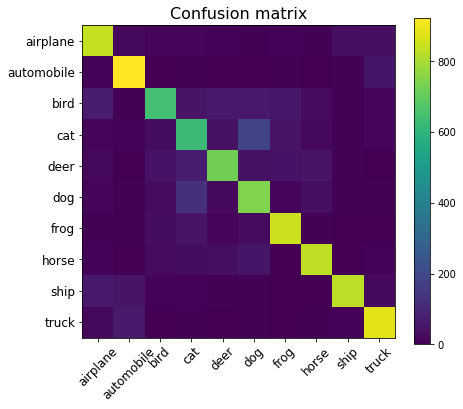

Test accuracy: 0.7908


In [45]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

In [46]:
## GRADED PART, DO NOT CHANGE!
# Accuracy on validation data
grader.set_answer("nQOsg", accuracy_score(y_test, y_pred_test_classes))

In [48]:
# token expires every 30 min
COURSERA_TOKEN = "fGLUNpRy2dGSc9th"
COURSERA_EMAIL = "tomar.ankur287@gmail.com"

In [49]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


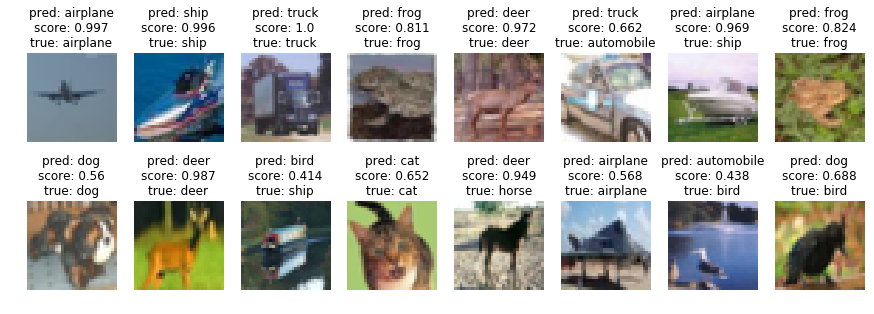

In [50]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Visualize maximum stimuli

We want to find input images that provide maximum activations for particular layers of our network. 

We will find those maximum stimuli via gradient ascent in image space.

For that task we load our model weights, calculate the layer output gradient with respect to image input and shift input image in that direction.

In [51]:
s = reset_tf_session()  # clear default graph
K.set_learning_phase(0)  # disable dropout
model = make_model()
model.load_weights("weights.h5")  # that were saved after model.fit

In [52]:
# all weights we have
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
__________

In [58]:
def find_maximum_stimuli(layer_name, is_conv, filter_index, model, iterations=20, step=1., verbose=True):
    
    def image_values_to_rgb(x):
        # normalize x: center on 0 (np.mean(x_train2)), ensure std is 0.25 (np.std(x_train2))
        # so that it looks like a normalized image input for our network
        x = (x-np.mean(x_train2))/(np.std(x_train2))

        # do reverse normalization to RGB values: x = (x_norm + 0.5) * 255
        x = (x + 0.5) * 255
    
        # clip values to [0, 255] and convert to bytes
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    # this is the placeholder for the input image
    input_img = model.input
    img_width, img_height = input_img.shape.as_list()[1:3]
    
    # find the layer output by name
    layer_output = list(filter(lambda x: x.name == layer_name, model.layers))[0].output

    # we build a loss function that maximizes the activation
    # of the filter_index filter of the layer considered
    if is_conv:
        # mean over feature map values for convolutional layer
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(layer_output[:, filter_index])

    # we compute the gradient of the loss wrt input image
    grads = K.gradients(loss, input_img)[0]  # [0] because of the batch dimension!

    # normalization trick: we normalize the gradient
    grads = grads / (K.sqrt(K.sum(K.square(grads))) + 1e-10)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * (0.1 if is_conv else 0.001)

    # we run gradient ascent
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if verbose:
            print('Current loss value:', loss_value)

    # decode the resulting input image
    img = image_values_to_rgb(input_img_data[0])
    
    return img, loss_value

In [59]:
# sample maximum stimuli
def plot_filters_stimuli(layer_name, is_conv, model, iterations=20, step=1., verbose=False):
    cols = 8
    rows = 2
    filter_index = 0
    max_filter_index = list(filter(lambda x: x.name == layer_name, model.layers))[0].output.shape.as_list()[-1] - 1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                loss = -1e20
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(layer_name, is_conv, filter_index, model,
                                                         iterations, step, verbose=verbose)
                    filter_index += 1
                if loss > 0:
                    ax.imshow(stimuli)
                    ax.set_title("Filter #{}".format(filter_index))
    plt.show()

leaky_re_lu_1


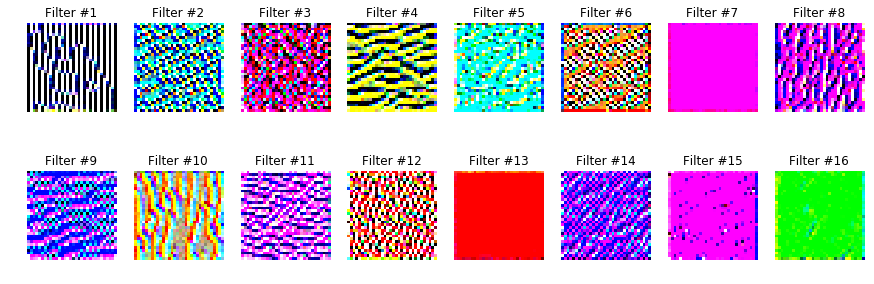

leaky_re_lu_2


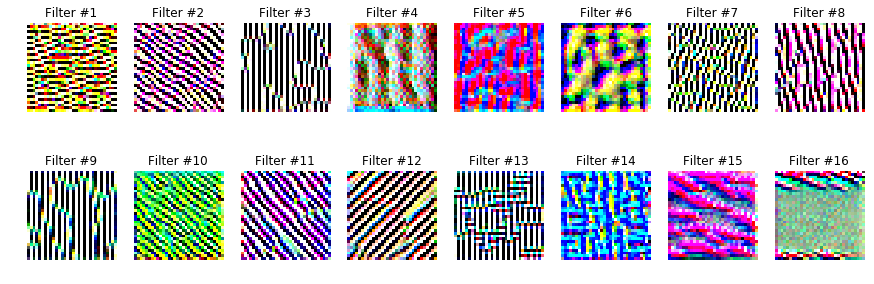

leaky_re_lu_3


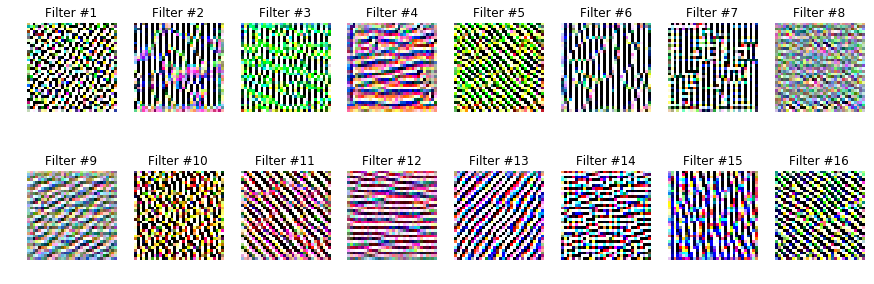

leaky_re_lu_4


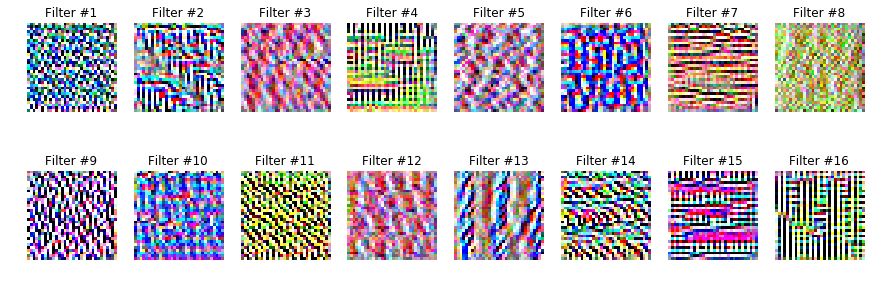

In [60]:
# maximum stimuli for convolutional neurons
conv_activation_layers = []
for layer in model.layers:
    if isinstance(layer, LeakyReLU):
        prev_layer = layer._inbound_nodes[0].inbound_layers[0]
        if isinstance(prev_layer, Conv2D):
            conv_activation_layers.append(layer)

for layer in conv_activation_layers:
    print(layer.name)
    plot_filters_stimuli(layer_name=layer.name, is_conv=True, model=model)

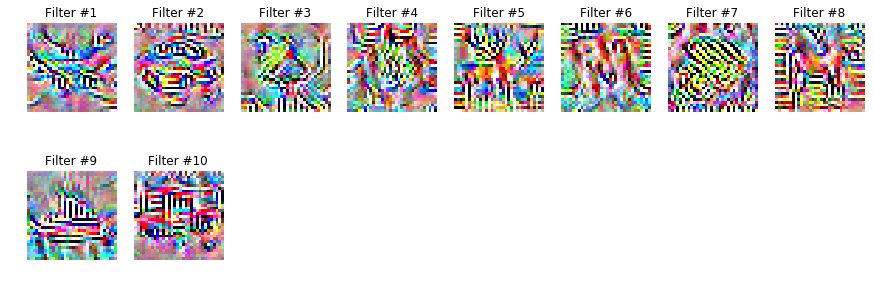

In [61]:
# maximum stimuli for last dense layer
last_dense_layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
plot_filters_stimuli(layer_name=last_dense_layer.name, is_conv=False, 
                     iterations=200, step=0.1, model=model)

In [62]:
def maximum_stimuli_test_for_grader():
    layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
    output_index = 7
    stimuli, loss = find_maximum_stimuli(
        layer_name=layer.name, 
        is_conv=False, 
        filter_index=output_index,
        model=model,
        verbose=False
    )
    return model.predict_proba(stimuli[np.newaxis, :])[0, output_index]

In [63]:
## GRADED PART, DO NOT CHANGE!
# Maximum stimuli test
grader.set_answer("96eco", maximum_stimuli_test_for_grader())

In [64]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


That's it! Congratulations!

What you've done:
- defined CNN architecture
- trained your model
- evaluated your model
- visualised learnt filters